In [90]:
# Import libraries.

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm

# Font management
georgia_regular = '/home/clarasmith/Sync/Fall 2025/SI/SI_Data/Vizzes/georgia-2/georgia.ttf'  # Replace with your actual path
georgia_bold = '/home/clarasmith/Sync/Fall 2025/SI/SI_Data/Vizzes/georgia-2/georgiab.ttf'    # Replace with your actual path

fm.fontManager.addfont(georgia_regular)
fm.fontManager.addfont(georgia_bold)

# NLP - Core
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.tokens import Doc

# NLP - NLTK
import nltk
from nltk.corpus import opinion_lexicon
from nltk.tokenize import word_tokenize
nltk.download('opinion_lexicon')
nltk.download('punkt')

# NLP - Sklearn
from sklearn.feature_extraction.text import CountVectorizer

# NLP - Advanced (Topic Modeling)
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic

# Utilities
import re
import ast
from collections import Counter

# spacy.cli.download('en_core_web_sm')

[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     /home/clarasmith/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /home/clarasmith/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Read in preprocessed dataframe, made out of BIOL 10103.
df = pd.read_csv("sentiment_df_analysis")

In [3]:
# Import Spacy's pipeline, disabling the resource intensive bits.
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])  


In [4]:
# Quickly document some possible abbreviations.
abbr_map = {
    "si": "Supplemental Instruction",
    "prof": "instructor",
    "ta": "teaching assistant"
}

In [5]:
# Normalize all text in survey data such that abbreviations are consistent
# And all text is lowercase to filter case errors. 
def normalize_text(text):
    text = text.lower() # Lowercase replacements. 
    for abbr, full in abbr_map.items(): # Replace abbreviations
        text = re.sub(rf"\b{abbr}\b", full.lower(), text)
    return text

In [6]:
# Preprocess text utilizing the above preprocessing function.
# Cleans for NLP analysis.

# Function that takes as input the raw text of the survey.
def preprocess_text(text):
    text = normalize_text(text) # Apply the above function to text data.
    doc = nlp(text) # Run SpaCy's NLP pipeline, including tokenization and POS-tagging.
    
    # Keep meaningful tokens: remove stopwords but keep punctuation if sentiment matters.
    tokens = [
        token.lemma_ if token.lemma_ != "-PRON-" else token.text
        for token in doc
        if not token.is_stop and not token.is_space
    ]
    
    # Return back all tokens for the responses.
    return tokens


In [7]:
# A function that applies regex (text formatting).
# In particular, reduces repeated characters down to two. 
# So 'hellooooo' becomes 'helloo' at maximum. Done to reduce prevalence of typos. 
def normalize_repeated_chars(text):
    return re.sub(r"(.)\1{2,}", r"\1\1", text)  # limit repeated characters to 2


In [ ]:
# Apply preprocessing directly to the DataFrame column.
# Takes raw text, and breaks them into a list of separated tokens, or words with meaning.
df["processed_tokens"] = df["response"].apply(
    lambda x: preprocess_text(normalize_repeated_chars(x))
)


In [10]:
display(df)

,question_id,question_text,response,processed_tokens
0,Q12,How has working collaboratively with your SI c...,Working collaboratively with my SI classmates ...,"[work, collaboratively, supplemental, instruct..."
1,Q12,How has working collaboratively with your SI c...,It went well!,"[go, !]"
2,Q12,How has working collaboratively with your SI c...,It give me a better understanding of the subject.,"[well, understanding, subject, .]"
3,Q12,How has working collaboratively with your SI c...,I better remember the material,"[well, remember, material]"
4,Q12,How has working collaboratively with your SI c...,It meant that we were all able to help cover k...,"[mean, able, help, cover, knowledge, know, .]"
...,...,...,...,...
897,Q14,What suggestions do you have for improving the...,I think having more SI class times available w...,"[think, have, supplemental, instruction, class..."
898,Q14,What suggestions do you have for improving the...,nothing it is working great for me,"[work, great]"
899,Q14,What suggestions do you have for improving the...,Make the info more beneficial and go over more...,"[info, beneficial, practice, problem, ., make,..."
900,Q14,What suggestions do you have for improving the...,Nothing,[]


In [11]:
# Break token list into strings for n-gram extraction
df["processed_text"] = df["processed_tokens"].apply(lambda x: " ".join(x))


In [12]:
display(df)

,question_id,question_text,response,processed_tokens,processed_text
0,Q12,How has working collaboratively with your SI c...,Working collaboratively with my SI classmates ...,"[work, collaboratively, supplemental, instruct...",work collaboratively supplemental instruction ...
1,Q12,How has working collaboratively with your SI c...,It went well!,"[go, !]",go !
2,Q12,How has working collaboratively with your SI c...,It give me a better understanding of the subject.,"[well, understanding, subject, .]",well understanding subject .
3,Q12,How has working collaboratively with your SI c...,I better remember the material,"[well, remember, material]",well remember material
4,Q12,How has working collaboratively with your SI c...,It meant that we were all able to help cover k...,"[mean, able, help, cover, knowledge, know, .]",mean able help cover knowledge know .
...,...,...,...,...,...
897,Q14,What suggestions do you have for improving the...,I think having more SI class times available w...,"[think, have, supplemental, instruction, class...",think have supplemental instruction class time...
898,Q14,What suggestions do you have for improving the...,nothing it is working great for me,"[work, great]",work great
899,Q14,What suggestions do you have for improving the...,Make the info more beneficial and go over more...,"[info, beneficial, practice, problem, ., make,...",info beneficial practice problem . make require .
900,Q14,What suggestions do you have for improving the...,Nothing,[],


In [13]:
# Extract ngrams from responses.
# An ngram is a combination of words that may contain meaning.
# Bigram = 2 words = "able talk, classmate help, remember material"
# Trigram = 3 words = "able help classmate, helpful practice problem"

# Define the function
def get_ngrams_safe(text, ngram_range=(2,3)): # ngram_range for two and three combinations.
    if not text.strip(): # If a response is empty
        return [] # Return an empty list to avoid errors. 
    vectorizer = CountVectorizer(ngram_range=ngram_range) # A special tool that extracts ngrams from responses.
    try:
        X = vectorizer.fit_transform([text]) # The line that does the actual extraction.
        return vectorizer.get_feature_names_out().tolist() # Grabs found phrases, puts them in a list.
    except ValueError:
        return []  # Error out an empty list if the above commands fail to run.


In [14]:
# Run the above function.
df["ngrams"] = df["processed_text"].apply(lambda x: get_ngrams_safe(x))


In [25]:
# Examine the results. 
display(df.head(5))

,question_id,question_text,response,processed_tokens,processed_text,ngrams,pos_tokens,nouns,verbs,adjectives,adverbs
0,Q12,How has working collaboratively with your SI c...,Working collaboratively with my SI classmates ...,"[work, collaboratively, supplemental, instruct...",work collaboratively supplemental instruction ...,"[able talk, able talk concept, classmate help,...","{'nouns': ['instruction', 'classmate', 'help',...","[instruction, classmate, help, semester, talk,...","[work, simplify]","[supplemental, able]",[collaboratively]
1,Q12,How has working collaboratively with your SI c...,It went well!,"[go, !]",go !,[],"{'nouns': [], 'verbs': ['go'], 'adjectives': [...",[],[go],[],[]
2,Q12,How has working collaboratively with your SI c...,It give me a better understanding of the subject.,"[well, understanding, subject, .]",well understanding subject .,"[understanding subject, well understanding, we...","{'nouns': ['subject'], 'verbs': ['understand']...",[subject],[understand],[],[]
3,Q12,How has working collaboratively with your SI c...,I better remember the material,"[well, remember, material]",well remember material,"[remember material, well remember, well rememb...","{'nouns': ['material'], 'verbs': ['remember'],...",[material],[remember],[],[]
4,Q12,How has working collaboratively with your SI c...,It meant that we were all able to help cover k...,"[mean, able, help, cover, knowledge, know, .]",mean able help cover knowledge know .,"[able help, able help cover, cover knowledge, ...","{'nouns': ['help', 'knowledge'], 'verbs': ['me...","[help, knowledge]","[mean, cover, know]",[able],[]


In [16]:
# Sentiment lexicon setup

# opinion_lexicon is a remote dataset from NLTK, containing roughly 6800 words that are labeled positive and negative. 
# We're just breaking this remote dataset into parts, where the positive ones are saved in one variable,
# And the negative ones are saved in another. 
# https://www.nltk.org/_modules/nltk/corpus/reader/opinion_lexicon.html
pos_words = set(opinion_lexicon.positive())
neg_words = set(opinion_lexicon.negative())

In [17]:
# Define some more functions that create different extractions.

# Extract the counts of positive and negative words within a list of word tokens. 
def sentiment_counts(tokens):
    pos_count = sum(1 for t in tokens if t in pos_words)
    neg_count = sum(1 for t in tokens if t in neg_words)
    return pos_count, neg_count # Return them as a tuple.

# Extract POS (Parts of Speech) words.
def pos_words_extract(text):
    doc = nlp(text) # Use SpaCy NLP on raw text.
    # Return a dictionary that contains lists of nouns, verbs, adjectives, and adverbs. All lower case for safety. 
    return {
        "nouns": [token.lemma_.lower() for token in doc if token.pos_ == "NOUN"],
        "verbs": [token.lemma_.lower() for token in doc if token.pos_ == "VERB"],
        "adjectives": [token.lemma_.lower() for token in doc if token.pos_ == "ADJ"],
        "adverbs": [token.lemma_.lower() for token in doc if token.pos_ == "ADV"]
    }

In [ ]:
# Apply new functions.

# Apply function to extract Parts of Speech dictionary of each response.
df["pos_tokens"] = df["processed_text"].apply(pos_words_extract) # Dictionary

# Apply functions to extract the individual dictionary entries and their contents, i.e. the parts of speech itself.
df["nouns"] = df["pos_tokens"].apply(lambda x: x["nouns"])
df["verbs"] = df["pos_tokens"].apply(lambda x: x["verbs"])
df["adjectives"] = df["pos_tokens"].apply(lambda x: x["adjectives"])
df["adverbs"] = df["pos_tokens"].apply(lambda x: x["adverbs"])

In [26]:
# Display first five entries of dataframe to check out results. 
# They look good.
display(df.head(5))

,question_id,question_text,response,processed_tokens,processed_text,ngrams,pos_tokens,nouns,verbs,adjectives,adverbs
0,Q12,How has working collaboratively with your SI c...,Working collaboratively with my SI classmates ...,"[work, collaboratively, supplemental, instruct...",work collaboratively supplemental instruction ...,"[able talk, able talk concept, classmate help,...","{'nouns': ['instruction', 'classmate', 'help',...","[instruction, classmate, help, semester, talk,...","[work, simplify]","[supplemental, able]",[collaboratively]
1,Q12,How has working collaboratively with your SI c...,It went well!,"[go, !]",go !,[],"{'nouns': [], 'verbs': ['go'], 'adjectives': [...",[],[go],[],[]
2,Q12,How has working collaboratively with your SI c...,It give me a better understanding of the subject.,"[well, understanding, subject, .]",well understanding subject .,"[understanding subject, well understanding, we...","{'nouns': ['subject'], 'verbs': ['understand']...",[subject],[understand],[],[]
3,Q12,How has working collaboratively with your SI c...,I better remember the material,"[well, remember, material]",well remember material,"[remember material, well remember, well rememb...","{'nouns': ['material'], 'verbs': ['remember'],...",[material],[remember],[],[]
4,Q12,How has working collaboratively with your SI c...,It meant that we were all able to help cover k...,"[mean, able, help, cover, knowledge, know, .]",mean able help cover knowledge know .,"[able help, able help cover, cover knowledge, ...","{'nouns': ['help', 'knowledge'], 'verbs': ['me...","[help, knowledge]","[mean, cover, know]",[able],[]


In [27]:
# Converts stored lists (strings) into actual python object lists.
# Inconsequential to main processing.

def safe_parse_list(x):
    # if it's already a list, just return as a list.
    if isinstance(x, (list, np.ndarray)):
        return list(x) if len(x) > 0 else []
    
    # If it's data type 'None' or an empty string, return an empty list.
    if x is None or (isinstance(x, str) and x.strip() == ''):
        return []
    
    # If it's NaN, return an empty list.
    try:
        if pd.isna(x): 
            return []
    except (ValueError, TypeError):
        pass
    
    # If string, parse it. 
    if isinstance(x, str):
        try:
            parsed = ast.literal_eval(x)
            return parsed if isinstance(parsed, list) else []
        except:
            return []
    
    # If everything fails, return an empty list.
    return []

In [ ]:
# Create a question overview. 
# Make a table that displays question statistics.

# Define function.
def create_question_overview(df):
    # Group all responses by which question is being answered. 
    overview = df.groupby('question_id').agg({
        'response': ['count', lambda x: x.notna().sum()], # Count responses.
        'processed_text': lambda x: x.str.split().str.len().mean() # Counts words, take mean.
    }).round(2)
    
    # Makes columms for the table display.
    overview.columns = ['Total Responses', 'Valid Responses', 'Avg Words per Response'] 
    overview = overview.reset_index()
    
    # Print title.
    print("Question Overview")
    print(overview.to_string(index=False))
    
    return overview

In [ ]:
# Print overview table.
create_question_overview(df)

Question Overview
question_id  Total Responses  Valid Responses  Avg Words per Response
        Q12              342              342                    8.03
        Q13              289              289                    6.11
        Q14              271              271                    6.37


,question_id,Total Responses,Valid Responses,Avg Words per Response
0,Q12,342,342,8.03
1,Q13,289,289,6.11
2,Q14,271,271,6.37


In [32]:
# Analyze most frequent bigrams for each question.

def create_ngram_analysis(df, top_n=15):
    # Dictionary to store results for each question.
    results = {}
    
    # Collect all ngrams for the current question.
    # Loops through Q12, Q13, Q14
    for q_id in df['question_id'].unique():
        q_data = df[df['question_id'] == q_id]
        
        # Collect all ngrams.
        all_ngrams = []
        for ngrams in q_data['ngrams']:
            parsed = safe_parse_list(ngrams)
            all_ngrams.extend(parsed) # Add all phrases to one ginormous list.
        
        # Count frequencies.
        ngram_counts = Counter(all_ngrams)
        top_ngrams = ngram_counts.most_common(top_n)
        
        # Create dataframe.
        ngram_df = pd.DataFrame(top_ngrams, columns=['Bigram', 'Frequency'])
        total = len(all_ngrams)
        ngram_df['Percentage'] = (ngram_df['Frequency'] / total * 100).round(2) # Computes frequency of ngrams within question.
        ngram_df['Rank'] = range(1, len(ngram_df) + 1)
        
        # Save all ngrams for that specific question.
        results[q_id] = ngram_df
        
        # Print out the top bigrams.
        print(f"Top {top_n} Bigrams - {q_id}")
        print(ngram_df.to_string(index=False))
    
    return results

In [38]:
create_ngram_analysis(df)

Top 15 Bigrams - Q12
                            Bigram  Frequency  Percentage  Rank
                   help understand         42        1.10     1
          supplemental instruction         31        0.81     2
                understand concept         28        0.73     3
                         help well         22        0.57     4
                   well understand         21        0.55     5
                        help learn         18        0.47     6
              work collaboratively         17        0.44     7
              help well understand         15        0.39     8
                    classmate help         13        0.34     9
                      concept well         13        0.34    10
                    course concept         12        0.31    11
           help understand concept         12        0.31    12
                     different way         12        0.31    13
             instruction classmate         11        0.29    14
supplemental instru

{'Q12':                                 Bigram  Frequency  Percentage  Rank
 0                      help understand         42        1.10     1
 1             supplemental instruction         31        0.81     2
 2                   understand concept         28        0.73     3
 3                            help well         22        0.57     4
 4                      well understand         21        0.55     5
 5                           help learn         18        0.47     6
 6                 work collaboratively         17        0.44     7
 7                 help well understand         15        0.39     8
 8                       classmate help         13        0.34     9
 9                         concept well         13        0.34    10
 10                      course concept         12        0.31    11
 11             help understand concept         12        0.31    12
 12                       different way         12        0.31    13
 13               instructi

In [40]:
# Analyze top words by parts of speech for each question.

# Define function, with a variable number of words that can be shown (default is ten).
def create_pos_analysis(df, top_n=10):
    
    # Access columns by position to avoid duplicate name issues.
    pos_categories = {
        7: 'Nouns (Concepts/Topics)',
        8: 'Verbs (Actions)',
        9: 'Adjectives (Descriptions)',
        10: 'Adverbs (Manner)'
    }
    
    # For Q12, Q13, Q14
    for q_id in df['question_id'].unique():
        q_data = df[df['question_id'] == q_id]
        
        print(f"{q_id}: Keywords by Part of Speech")
        
        # Empty list to hold the summary data for every individual question.
        summary_data = []
        
        # Loop through each POS category.
        # pos_idx is the column number above.
        # The label is the description (noun, adjective...)
        for pos_idx, label in pos_categories.items():
            # Collect all words for this POS using column index
            all_words = [] # Empty list to collect all words.
            for words in q_data.iloc[:, pos_idx]:
                parsed = safe_parse_list(words)
                all_words.extend(parsed)
            
            # Count frequencies.
            word_counts = Counter(all_words)
            top_words = word_counts.most_common(top_n)
            
            # If there are indeed, words and this isn't empty.
            if top_words:
                # Create a formatted string that lists the top five words and their counts. 
                words_str = ', '.join([f"{word} ({count})" for word, count in top_words[:5]])
                summary_data.append({ # Add summary data.
                    'Category': label,
                    'Total Occurrences': len(all_words),
                    'Unique Words': len(word_counts),
                    'Top 5': words_str
                })
        
        # Squash into a dataframe.
        summary_df = pd.DataFrame(summary_data)
        print(summary_df.to_string(index=False))

In [ ]:
# Print POS table.
create_pos_analysis(df)

Q12: Keywords by Part of Speech
                 Category  Total Occurrences  Unique Words                                                                  Top 5
  Nouns (Concepts/Topics)               1191           210         help (135), concept (110), work (37), classmate (36), way (35)
          Verbs (Actions)                684           113         understand (126), help (88), learn (50), work (27), think (27)
Adjectives (Descriptions)                321            88   able (41), helpful (36), supplemental (31), different (27), new (19)
         Adverbs (Manner)                137            40 well (69), collaboratively (17), truly (2), actually (2), honestly (2)
Q13: Keywords by Part of Speech
                 Category  Total Occurrences  Unique Words                                                                Top 5
  Nouns (Concepts/Topics)                656           187  instruction (52), leader (51), suggestion (28), job (28), help (19)
          Verbs (Actions)     

In [42]:
# Table for student response lengths. 

# Define function.
def create_length_analysis(df):
    print("Response Lengths")
    # Empty list to hold length data.
    length_data = []
    
    # For each question.
    for q_id in df['question_id'].unique():
        q_data = df[df['question_id'] == q_id].copy()
        q_data['word_count'] = q_data['processed_text'].str.split().str.len() # Count words.
        
        # See if you can compute a standard deviation of lengths for each question.
        std_val = q_data['word_count'].std()
        
        # Add statistics. 
        length_data.append({
            'Question': q_id,
            'Mean Words': round(q_data['word_count'].mean(), 1),
            'Median Words': q_data['word_count'].median(),
            'Min Words': q_data['word_count'].min(),
            'Max Words': q_data['word_count'].max(),
            'Std Dev': round(std_val, 1) if pd.notna(std_val) else 0.0
        })
    
    # Create a dataframe out of this. 
    length_df = pd.DataFrame(length_data)
    print(length_df.to_string(index=False))

In [43]:
create_length_analysis(df)

Response Lengths
Question  Mean Words  Median Words  Min Words  Max Words  Std Dev
     Q12         8.0           7.0          0         29      5.3
     Q13         6.1           4.0          0         49      6.3
     Q14         6.4           4.0          0         60      7.3


In [46]:
def create_theme_summary(df, top_n=5):
    print("Theme Summaries")
    
    # For each question.
    for q_id in df['question_id'].unique():
        q_data = df[df['question_id'] == q_id]
        
        # If question exists, print.
        print(f"\n{q_id}: {q_data['question_text'].iloc[0] if 'question_text' in df.columns else q_id}")
        
        # Get top bigrams.
        all_ngrams = []
        for ngrams in q_data['ngrams']:
            all_ngrams.extend(safe_parse_list(ngrams))
        top_bigrams = Counter(all_ngrams).most_common(top_n)
        
        # Get top nouns.
        all_nouns = []
        for nouns in q_data.iloc[:, 7]:
            all_nouns.extend(safe_parse_list(nouns))
        top_nouns = Counter(all_nouns).most_common(top_n)
        
        # Get top adjectives. 
        all_adj = []
        for adj in q_data.iloc[:, 9]:
            all_adj.extend(safe_parse_list(adj))
        top_adj = Counter(all_adj).most_common(top_n)
        
        # Make this in a dataframe.
        theme_df = pd.DataFrame({
            'Key Phrases': [bg[0] for bg in top_bigrams],
            'Frequency': [bg[1] for bg in top_bigrams],
            'Top Concepts': [n[0] if n else '' for n in top_nouns],
            'Descriptors': [a[0] if a else '' for a in top_adj]
        })
        
        print(theme_df.to_string(index=False))

In [ ]:
# Print theme table.
create_theme_summary(df)

Theme Summaries

Q12: How has working collaboratively with your SI classmates contributed to your understanding of course concepts?
             Key Phrases  Frequency Top Concepts  Descriptors
         help understand         42         help         able
supplemental instruction         31      concept      helpful
      understand concept         28         work supplemental
               help well         22    classmate    different
         well understand         21          way          new

Q13: What suggestions do you have for improving your leader's performance?
                    Key Phrases  Frequency Top Concepts  Descriptors
       supplemental instruction         48  instruction        great
             instruction leader         33       leader supplemental
supplemental instruction leader         33   suggestion         good
                      great job         13          job      helpful
                   leader great         10         help      amazing

Q14: 

In [48]:
# Observe therre is a lot of uncaught stopwords related to SI.
# Filter some of these out to make more informative responses.
def create_filtered_dataframe(df, custom_stopwords=None):
    
    # Default context-specific stopwords for SI surveys.
    default_stopwords = {
        'supplemental', 'instruction', 'si', 'session', 'sessions',
        'leader', 'program', 'class', 'classmate', 'classmates',
        'course', 'student', 'students', 'question', 'questions',
        'would', 'could', 'one', 'also', 'get', 'make', 'thing', 'things',
        'really', 'think', 'feel', 'like', 'way', 'lot', 'much'
    }
    
    # Add custom stopwords if provided.
    if custom_stopwords:
        default_stopwords.update(custom_stopwords)
    
    # Create a copy of the dataframe. Call it df_filtered.
    df_filtered = df.copy()
    
    # Filter processed_tokens.
    if 'processed_tokens' in df.columns:
        df_filtered['processed_tokens'] = df_filtered['processed_tokens'].apply(
            lambda tokens: [t for t in tokens if t.lower() not in default_stopwords]
        )
    
    # Recreate processed_text from filtered tokens.
    if 'processed_tokens' in df.columns:
        df_filtered['processed_text'] = df_filtered['processed_tokens'].apply(lambda x: " ".join(x))
    
    # Filter POS columns by name.
    pos_columns = ['nouns', 'verbs', 'adjectives', 'adverbs']
    for pos_col in pos_columns:
        if pos_col in df.columns:
            df_filtered[pos_col] = df_filtered[pos_col].apply(
                lambda words: [w for w in safe_parse_list(words) if w.lower() not in default_stopwords]
            )
    
    # Filter ngrams - remove bigrams containing stopwords.
    if 'ngrams' in df.columns:
        df_filtered['ngrams'] = df_filtered['ngrams'].apply(
            lambda ngrams: [
                ng for ng in safe_parse_list(ngrams) 
                if not any(word in default_stopwords for word in ng.lower().split())
            ]
        )
    
    # Return the processed dataframe.
    return df_filtered

In [49]:
df_filtered = create_filtered_dataframe(df)

In [50]:
display(df_filtered)

,question_id,question_text,response,processed_tokens,processed_text,ngrams,pos_tokens,nouns,verbs,adjectives,adverbs
0,Q12,How has working collaboratively with your SI c...,Working collaboratively with my SI classmates ...,"[work, collaboratively, help, semester, able, ...",work collaboratively help semester able talk c...,"[able talk, able talk concept, concept simplif...","{'nouns': ['instruction', 'classmate', 'help',...","[help, semester, talk, concept, people, study,...","[work, simplify]",[able],[collaboratively]
1,Q12,How has working collaboratively with your SI c...,It went well!,"[go, !]",go !,[],"{'nouns': [], 'verbs': ['go'], 'adjectives': [...",[],[go],[],[]
2,Q12,How has working collaboratively with your SI c...,It give me a better understanding of the subject.,"[well, understanding, subject, .]",well understanding subject .,"[understanding subject, well understanding, we...","{'nouns': ['subject'], 'verbs': ['understand']...",[subject],[understand],[],[]
3,Q12,How has working collaboratively with your SI c...,I better remember the material,"[well, remember, material]",well remember material,"[remember material, well remember, well rememb...","{'nouns': ['material'], 'verbs': ['remember'],...",[material],[remember],[],[]
4,Q12,How has working collaboratively with your SI c...,It meant that we were all able to help cover k...,"[mean, able, help, cover, knowledge, know, .]",mean able help cover knowledge know .,"[able help, able help cover, cover knowledge, ...","{'nouns': ['help', 'knowledge'], 'verbs': ['me...","[help, knowledge]","[mean, cover, know]",[able],[]
...,...,...,...,...,...,...,...,...,...,...,...
897,Q14,What suggestions do you have for improving the...,I think having more SI class times available w...,"[have, time, available, beneficial, .]",have time available beneficial .,"[available beneficial, time available, time av...","{'nouns': ['instruction', 'class', 'time', 'pr...",[time],[],"[available, beneficial]",[]
898,Q14,What suggestions do you have for improving the...,nothing it is working great for me,"[work, great]",work great,[work great],"{'nouns': [], 'verbs': ['work'], 'adjectives':...",[],[work],[great],[]
899,Q14,What suggestions do you have for improving the...,Make the info more beneficial and go over more...,"[info, beneficial, practice, problem, ., requi...",info beneficial practice problem . require .,"[beneficial practice, beneficial practice prob...","{'nouns': ['info', 'practice', 'problem', 'req...","[info, practice, problem, require]",[],[beneficial],[]
900,Q14,What suggestions do you have for improving the...,Nothing,[],,[],"{'nouns': [], 'verbs': [], 'adjectives': [], '...",[],[],[],[]


In [51]:
# Rerun functions on the filtered dataframe
create_ngram_analysis(df_filtered)

Top 15 Bigrams - Q12
                 Bigram  Frequency  Percentage  Rank
        help understand         42        1.59     1
     understand concept         28        1.06     2
              help well         22        0.83     3
        well understand         21        0.79     4
             help learn         18        0.68     5
   work collaboratively         17        0.64     6
   help well understand         15        0.57     7
           concept well         13        0.49     8
help understand concept         12        0.45     9
     well understanding         11        0.42    10
well understand concept          9        0.34    11
        understand well          9        0.34    12
  understanding concept          8        0.30    13
    understand material          8        0.30    14
  different perspective          7        0.26    15
Top 15 Bigrams - Q13
                  Bigram  Frequency  Percentage  Rank
               great job         13        1.12     1
  

{'Q12':                      Bigram  Frequency  Percentage  Rank
 0           help understand         42        1.59     1
 1        understand concept         28        1.06     2
 2                 help well         22        0.83     3
 3           well understand         21        0.79     4
 4                help learn         18        0.68     5
 5      work collaboratively         17        0.64     6
 6      help well understand         15        0.57     7
 7              concept well         13        0.49     8
 8   help understand concept         12        0.45     9
 9        well understanding         11        0.42    10
 10  well understand concept          9        0.34    11
 11          understand well          9        0.34    12
 12    understanding concept          8        0.30    13
 13      understand material          8        0.30    14
 14    different perspective          7        0.26    15,
 'Q13':                       Bigram  Frequency  Percentage  Ran

In [52]:
create_pos_analysis(df_filtered)

Q12: Keywords by Part of Speech
                 Category  Total Occurrences  Unique Words                                                                  Top 5
  Nouns (Concepts/Topics)                946           198          help (135), concept (110), work (37), topic (35), people (33)
          Verbs (Actions)                629           108          understand (126), help (88), learn (50), work (27), know (25)
Adjectives (Descriptions)                290            87         able (41), helpful (36), different (27), new (19), certain (9)
         Adverbs (Manner)                136            39 well (69), collaboratively (17), truly (2), actually (2), honestly (2)
Q13: Keywords by Part of Speech
                 Category  Total Occurrences  Unique Words                                                             Top 5
  Nouns (Concepts/Topics)                470           176 suggestion (28), job (28), help (19), game (18), performance (14)
          Verbs (Actions)           

In [53]:
create_theme_summary(df_filtered)

Theme Summaries

Q12: How has working collaboratively with your SI classmates contributed to your understanding of course concepts?
       Key Phrases  Frequency Top Concepts Descriptors
   help understand         42         help        able
understand concept         28      concept     helpful
         help well         22         work   different
   well understand         21        topic         new
        help learn         18       people     certain

Q13: What suggestions do you have for improving your leader's performance?
        Key Phrases  Frequency Top Concepts Descriptors
          great job         13   suggestion       great
    help understand          7          job        good
           good job          7         help     helpful
improve performance          5         game     amazing
        ice breaker          4  performance      little

Q14: What suggestions do you have for improving the SI Program overall?
    Key Phrases  Frequency Top Concepts Descriptors
 

In [ ]:
# Save the results of the filtered ngram analysis into its own variable.
ngram_filtered_results = create_ngram_analysis(df_filtered)

# Visualize top phrases.
def plot_three_questions(results, questions=["Q12", "Q13", "Q14"], top_n=10):
    # UArk colors
    cardinal_red = '#9D2235'
    white = '#FFFFFF'
    dark_gray = '#333333'
    
    # Set up the canvas that these visualizations will be overlayed on.
    fig = plt.figure(figsize=(18, 11), facecolor=white)
    
    # Add main title.
    fig.suptitle('Frequency of N-grams for BIOL 1103 Spring 2025 Student Survey Responses', 
                 fontsize=20, weight='bold', color=cardinal_red, y=0.98)

    # For all questions, go through their responses and visualize their results.
    for i, q in enumerate(questions, 1):
        df = results[q].head(top_n)

        ax = plt.subplot(1, 3, i)
        
        colors = [cardinal_red] * len(df)
        bars = ax.barh(df["Bigram"], df["Frequency"], color=colors, 
                       edgecolor=dark_gray, linewidth=1.2)
        
        ax.invert_yaxis()
        ax.set_facecolor(white)
        
        ax.set_title(f"{q}: Most Common Phrases", fontsize=14, weight="bold", 
                     color=cardinal_red, pad=15)
        ax.set_xlabel("Frequency (Percent of Responses)", fontsize=12, weight='bold', color=dark_gray)
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_color(dark_gray)
        ax.spines['bottom'].set_color(dark_gray)
        
        ax.tick_params(colors=dark_gray, labelsize=10)
        plt.yticks(fontsize=9)

        for idx, val in enumerate(df["Frequency"]):
            ax.text(val + 0.5, idx, str(val), va="center", fontsize=10, 
                   weight='bold', color=dark_gray)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

Top 15 Bigrams - Q12
                 Bigram  Frequency  Percentage  Rank
        help understand         42        1.59     1
     understand concept         28        1.06     2
              help well         22        0.83     3
        well understand         21        0.79     4
             help learn         18        0.68     5
   work collaboratively         17        0.64     6
   help well understand         15        0.57     7
           concept well         13        0.49     8
help understand concept         12        0.45     9
     well understanding         11        0.42    10
well understand concept          9        0.34    11
        understand well          9        0.34    12
  understanding concept          8        0.30    13
    understand material          8        0.30    14
  different perspective          7        0.26    15
Top 15 Bigrams - Q13
                  Bigram  Frequency  Percentage  Rank
               great job         13        1.12     1
  

findfont: Generic family 'serif' not found because none of the following families were found: Georgia, Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Georgia, Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Georgia, Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Georgia, Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Georgia, Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Georgia, Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Georgia, Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Georgia, Times New Roman
findfont: Generic family 'serif' not found becau

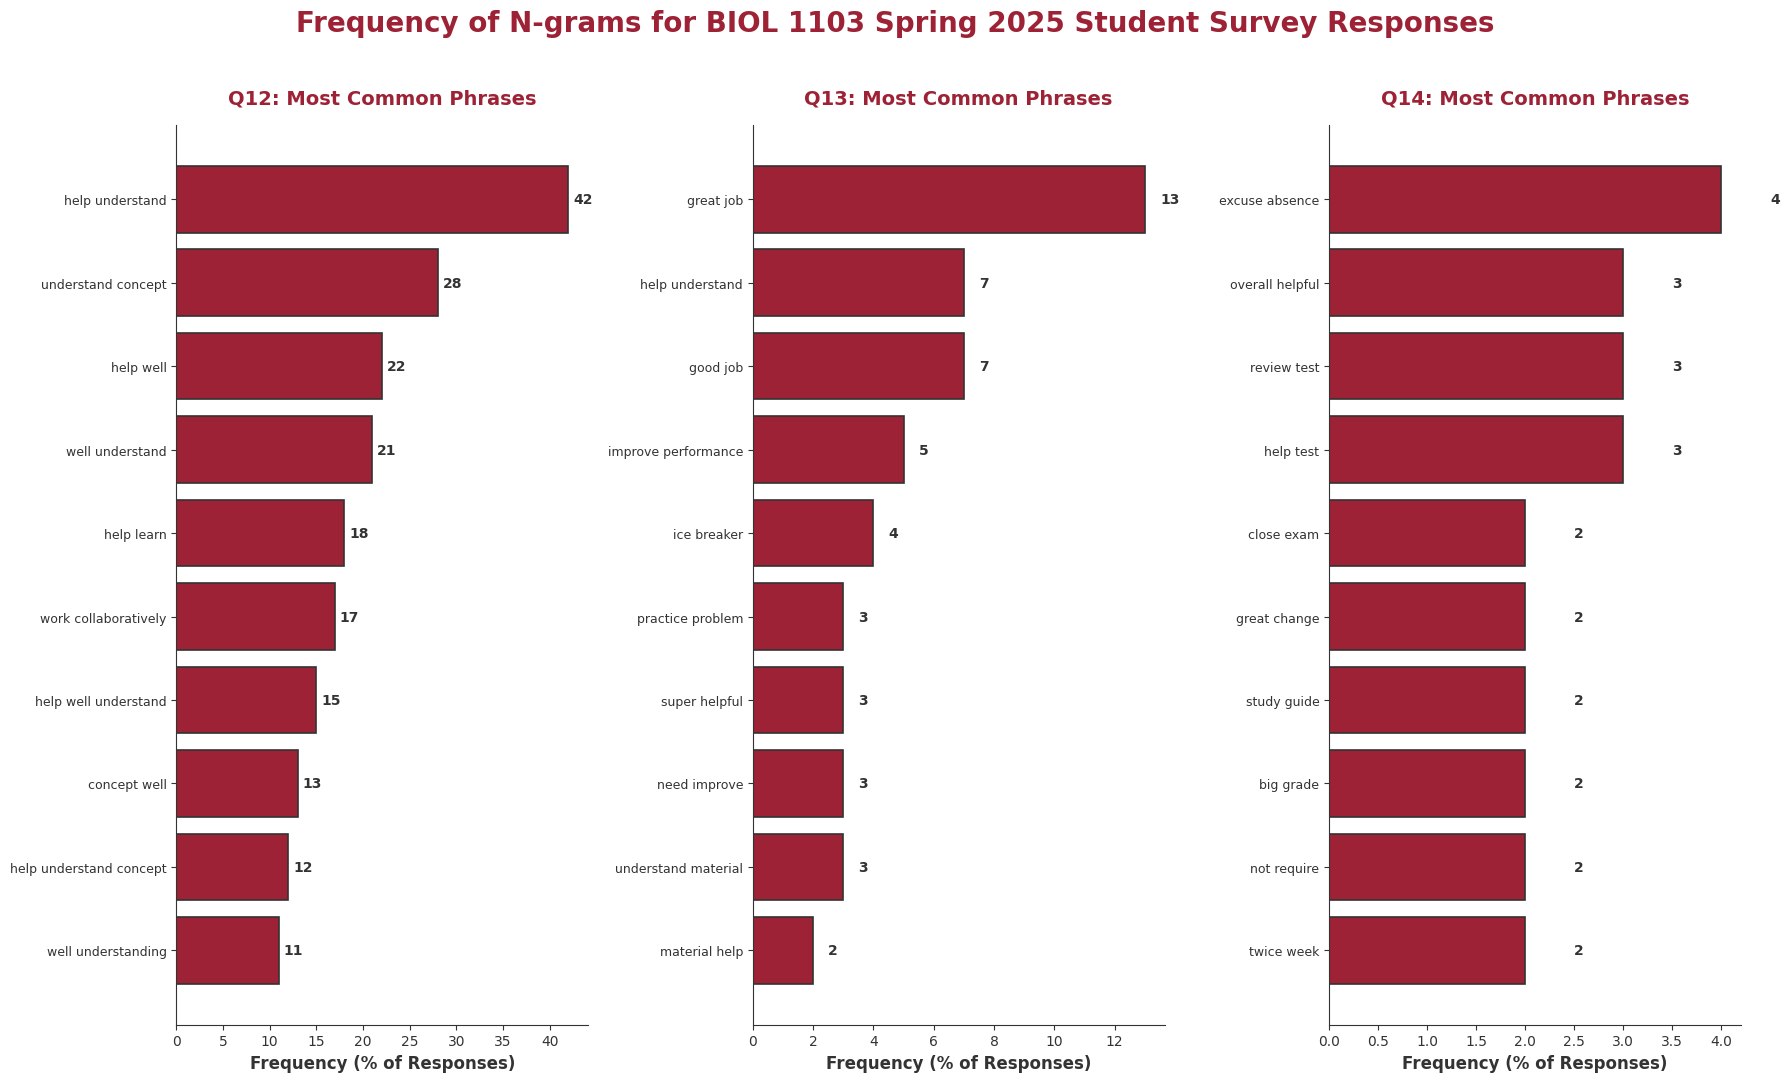

In [71]:
plot_three_questions(ngram_filtered_results)


In [79]:
# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

# Get the overview data
overview = create_question_overview(df_filtered)

Question Overview
question_id  Total Responses  Valid Responses  Avg Words per Response
        Q12              342              342                    7.03
        Q13              289              289                    4.98
        Q14              271              271                    4.85


Text(0.5, 1.0, 'Summary Table')

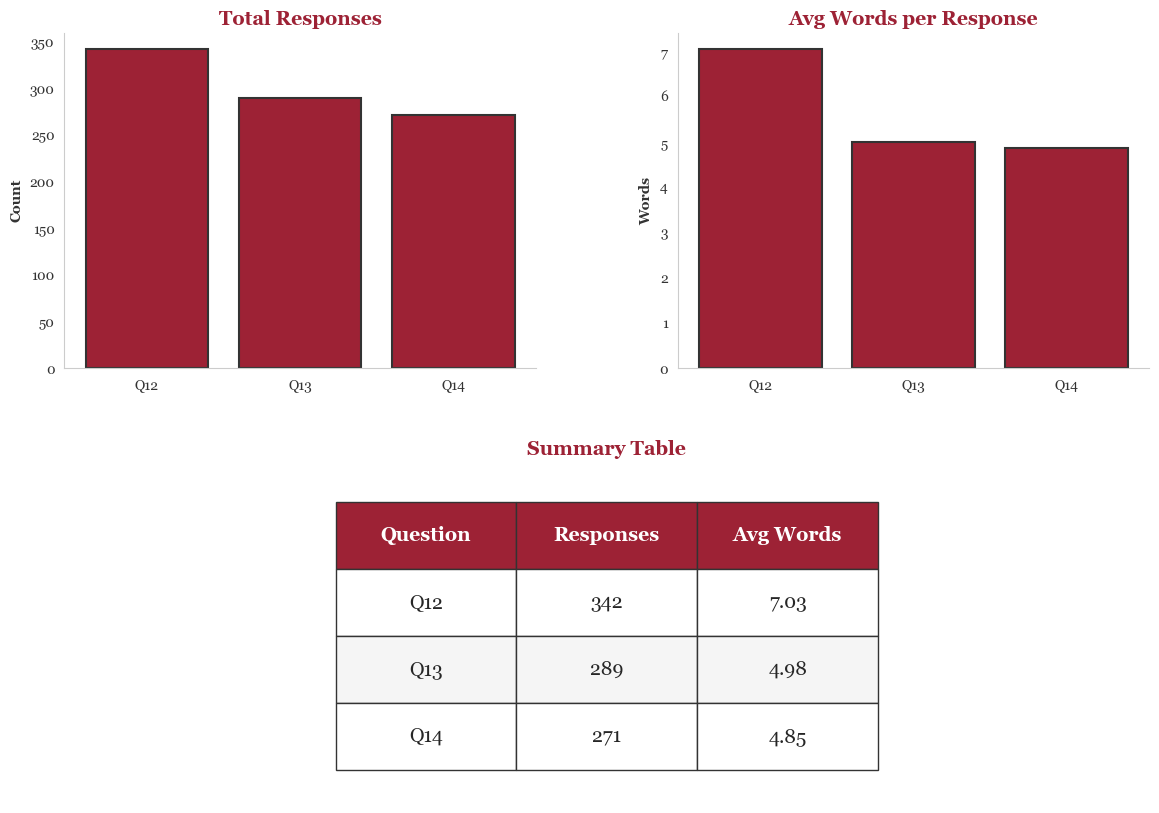

In [ ]:
# Color palette.
cardinal_red = '#9D2235'
white = '#FFFFFF'
dark_gray = '#333333'
light_gray = '#F5F5F5'

# Set Georgia font.
plt.rcParams['font.family'] = 'Georgia'

fig = plt.figure(figsize=(14, 10), facecolor=white)
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1], hspace=0.3, wspace=0.3)

# Top-left: Response counts.
ax1 = fig.add_subplot(gs[0, 0])
ax1.bar(overview['question_id'], overview['Total Responses'], 
        color=cardinal_red, edgecolor=dark_gray, linewidth=1.5)
ax1.set_ylabel('Count', fontweight='bold', color=dark_gray)
ax1.set_title('Total Responses', fontsize=14, fontweight='bold', color=cardinal_red)
ax1.set_facecolor(white)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.tick_params(colors=dark_gray)
ax1.grid(False)

# Top-right: Average words.
ax2 = fig.add_subplot(gs[0, 1])
ax2.bar(overview['question_id'], overview['Avg Words per Response'], 
        color=cardinal_red, edgecolor=dark_gray, linewidth=1.5)
ax2.set_ylabel('Words', fontweight='bold', color=dark_gray)
ax2.set_title('Avg Words per Response', fontsize=14, fontweight='bold', color=cardinal_red)
ax2.set_facecolor(white)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.tick_params(colors=dark_gray)
ax2.grid(False)

# Bottom: Summary table spanning both columns.
ax3 = fig.add_subplot(gs[1, :])
ax3.axis('tight')
ax3.axis('off')

table_data = overview[['question_id', 'Total Responses', 'Avg Words per Response']].values
table = ax3.table(cellText=table_data,
                  colLabels=['Question', 'Responses', 'Avg Words'],
                  cellLoc='center',
                  loc='center',  # This centers the table.
                  bbox=[0.25, 0.1, 0.5, 0.8])  # [left, bottom, width, height] to center it.

table.auto_set_font_size(False)
table.set_fontsize(14)
table.scale(1, 2.5)

# Style header - Cardinal Red.
for i in range(3):
    table[(0, i)].set_facecolor(cardinal_red)
    table[(0, i)].set_text_props(weight='bold', color=white)
    table[(0, i)].set_edgecolor(dark_gray)

# Alternate row colors - white and light gray.
for i in range(1, len(overview) + 1):
    for j in range(3):
        if i % 2 == 0:
            table[(i, j)].set_facecolor(light_gray)
        else:
            table[(i, j)].set_facecolor(white)
        table[(i, j)].set_edgecolor(dark_gray)

ax3.set_title('Summary Table', fontsize=14, fontweight='bold', pad=10, color=cardinal_red)

In [ ]:
# Set style.
sns.set_style("whitegrid")

# Get the ngram results.
ngram_results = create_ngram_analysis(df_filtered, top_n=15)

Top 15 Bigrams - Q12
                 Bigram  Frequency  Percentage  Rank
        help understand         42        1.59     1
     understand concept         28        1.06     2
              help well         22        0.83     3
        well understand         21        0.79     4
             help learn         18        0.68     5
   work collaboratively         17        0.64     6
   help well understand         15        0.57     7
           concept well         13        0.49     8
help understand concept         12        0.45     9
     well understanding         11        0.42    10
well understand concept          9        0.34    11
        understand well          9        0.34    12
  understanding concept          8        0.30    13
    understand material          8        0.30    14
  different perspective          7        0.26    15
Top 15 Bigrams - Q13
                  Bigram  Frequency  Percentage  Rank
               great job         13        1.12     1
  

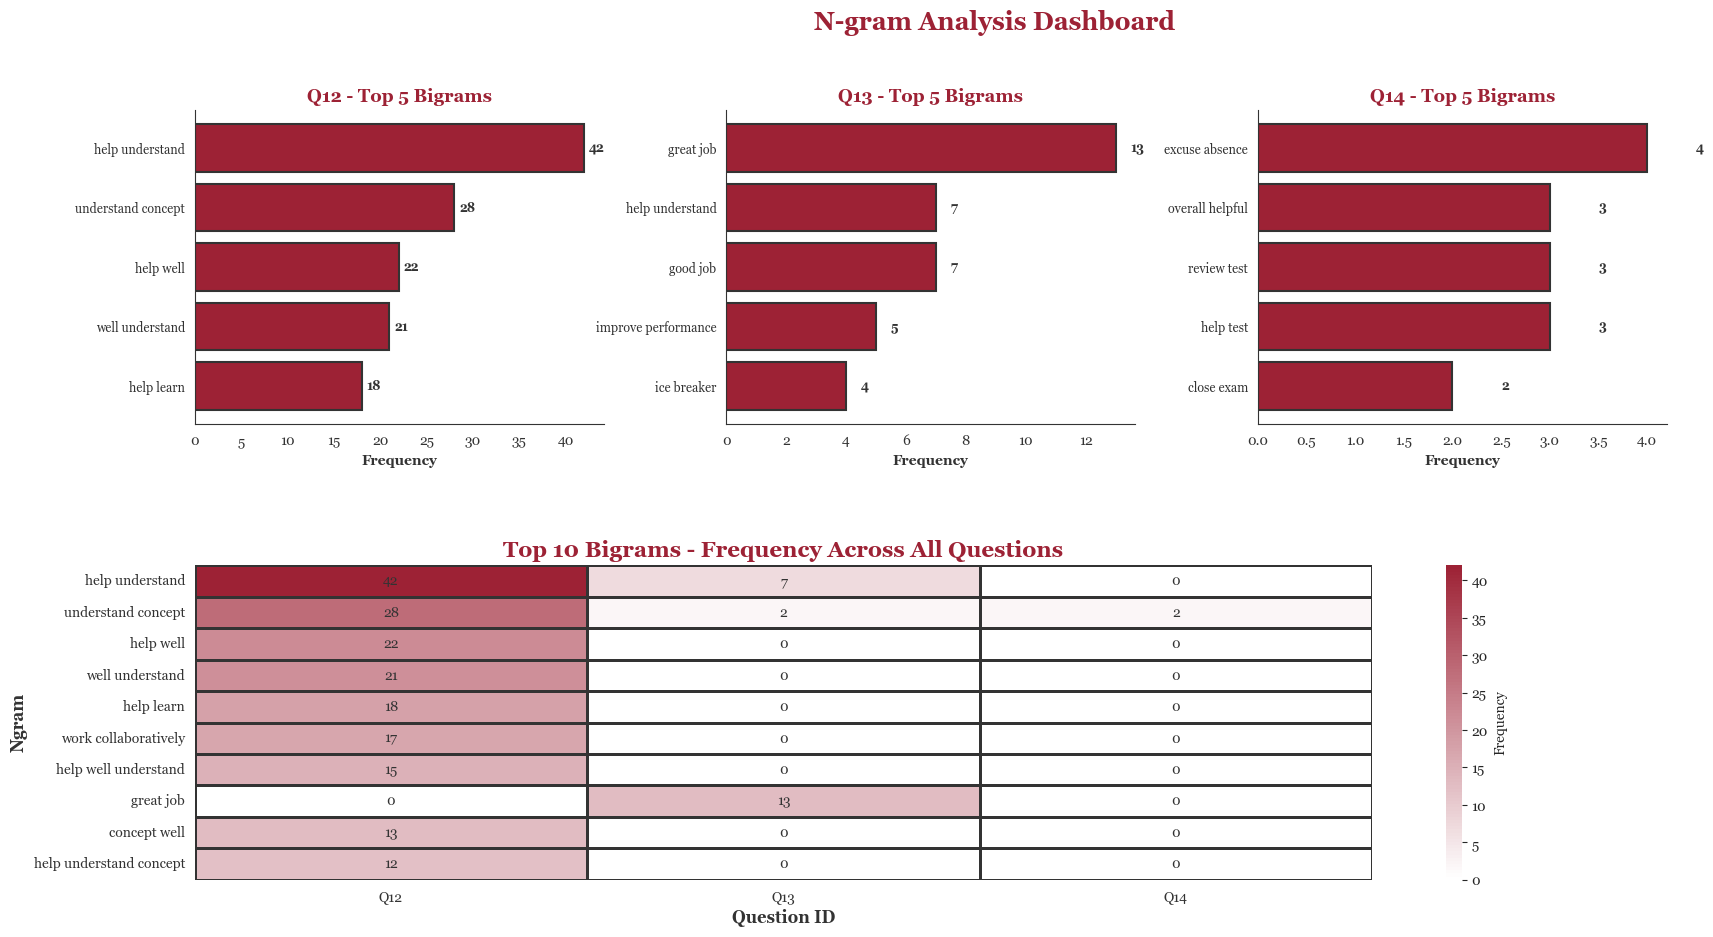

In [110]:
# Color palette.
cardinal_red = '#9D2235'
white = '#FFFFFF'
dark_gray = '#333333'

# Set Georgia font.
plt.rcParams['font.family'] = 'Georgia'

all_top_bigrams = set()
for ngram_df in ngram_results.values():
    all_top_bigrams.update(ngram_df.head(10)['Bigram'].tolist())

# Create matrix.
heatmap_data = []
question_ids = list(ngram_results.keys())

for bigram in all_top_bigrams:
    row = []
    for q_id in question_ids:
        # Find frequency of this bigram in this question.
        ngram_df = ngram_results[q_id]
        freq = ngram_df[ngram_df['Bigram'] == bigram]['Frequency'].values
        row.append(freq[0] if len(freq) > 0 else 0)
    heatmap_data.append(row)

# Convert to dataframe and sort by total frequency.
heatmap_df = pd.DataFrame(heatmap_data, columns=question_ids, index=list(all_top_bigrams))
heatmap_df['Total'] = heatmap_df.sum(axis=1)
heatmap_df = heatmap_df.sort_values('Total', ascending=False).drop('Total', axis=1)
heatmap_df = heatmap_df.head(10)

# Create Dashboard.
fig = plt.figure(figsize=(16, 10), facecolor=white)
gs = fig.add_gridspec(2, 3, hspace=0.45, wspace=0.3, 
                      left=0.0, right=0.92)  # Add margins on left and right.

# Top row: Individual question charts.
for idx, (q_id, ngram_df) in enumerate(ngram_results.items()):
    ax = fig.add_subplot(gs[0, idx])
    top_5 = ngram_df.head(5)
    
    bars = ax.barh(range(len(top_5)), top_5['Frequency'], 
                   color=cardinal_red, edgecolor=dark_gray, linewidth=1.5)
    
    ax.set_yticks(range(len(top_5)))
    ax.set_yticklabels(top_5['Bigram'], fontsize=9)
    ax.set_xlabel('Frequency', fontsize=10, fontweight='bold', color=dark_gray)
    ax.set_title(f'{q_id} - Top 5 Bigrams', fontsize=13, fontweight='bold', color=cardinal_red)
    ax.invert_yaxis()
    ax.set_facecolor(white)
    ax.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color(dark_gray)
    ax.spines['bottom'].set_color(dark_gray)
    ax.tick_params(colors=dark_gray)
    
    # Add frequency labels.
    for i, (bar, freq) in enumerate(zip(bars, top_5['Frequency'])):
        ax.text(freq + 0.5, i, str(freq), 
               va='center', fontsize=9, fontweight='bold', color=dark_gray)

# Bottom row: Heatmap spanning all columns.
ax_heat = fig.add_subplot(gs[1, :])

# Create custom colormap from white to cardinal red.
from matplotlib.colors import LinearSegmentedColormap
colors_map = [white, cardinal_red]
n_bins = 100
cmap = LinearSegmentedColormap.from_list('uark', colors_map, N=n_bins)

sns.heatmap(heatmap_df, annot=True, fmt='g', cmap=cmap, 
            linewidths=1, linecolor=dark_gray,
            cbar_kws={'label': 'Frequency'},
            ax=ax_heat, annot_kws={'fontsize': 10, 'color': dark_gray})

ax_heat.set_xlabel('Question ID', fontsize=12, fontweight='bold', color=dark_gray)
ax_heat.set_ylabel('Ngram', fontsize=12, fontweight='bold', color=dark_gray)
ax_heat.set_title('Top 10 Bigrams - Frequency Across All Questions', fontsize=16, fontweight='bold', color=cardinal_red)
ax_heat.tick_params(colors=dark_gray)

plt.suptitle('N-gram Analysis Dashboard', fontsize=18, fontweight='bold', 
             x=0.5, y=0.98, color=cardinal_red, ha='center')
plt.tight_layout()
plt.show()

In [112]:
# Set style
sns.set_style("whitegrid")

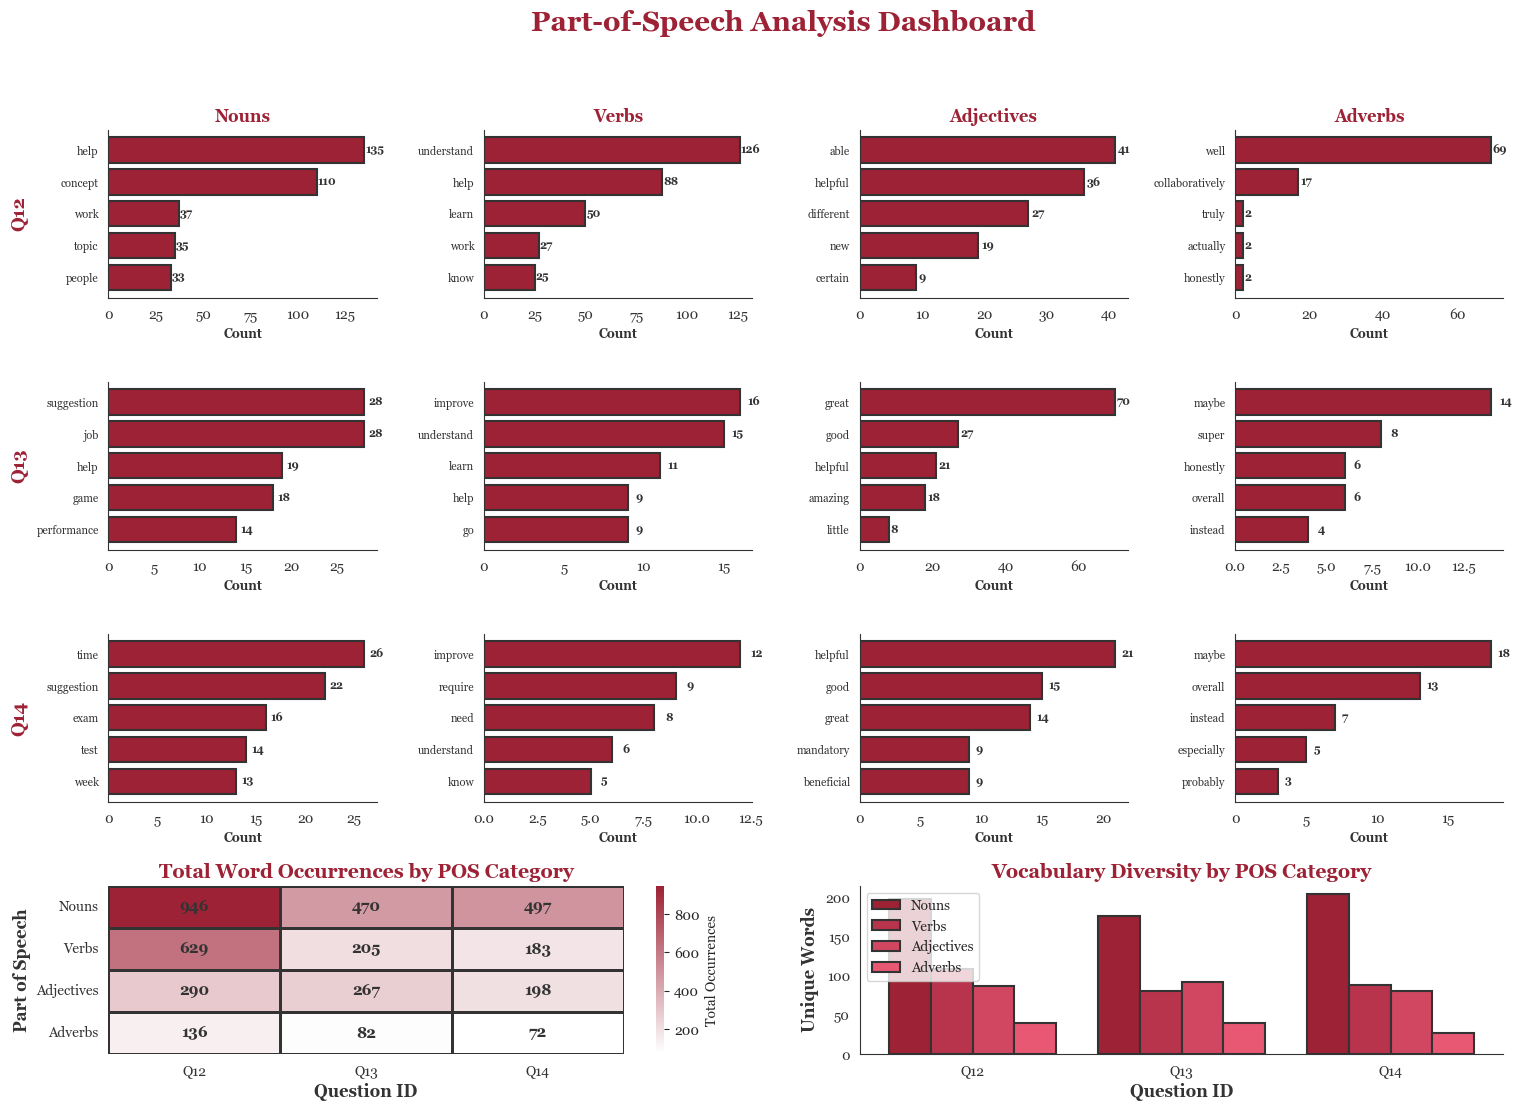

In [ ]:
# UArk colors
cardinal_red = '#9D2235'
white = '#FFFFFF'
dark_gray = '#333333'
light_gray = '#F5F5F5'

# Set Georgia font
plt.rcParams['font.family'] = 'Georgia'

pos_categories = {
    7: 'Nouns',
    8: 'Verbs',
    9: 'Adjectives',
    10: 'Adverbs'
}

# Store data for visualization
all_pos_data = {}

for q_id in df_filtered['question_id'].unique():
    q_data = df_filtered[df_filtered['question_id'] == q_id]
    all_pos_data[q_id] = {}
    
    for pos_idx, label in pos_categories.items():
        all_words = []
        for words in q_data.iloc[:, pos_idx]:
            parsed = safe_parse_list(words)
            all_words.extend(parsed)
        
        word_counts = Counter(all_words)
        all_pos_data[q_id][label] = {
            'counts': word_counts,
            'total': len(all_words),
            'unique': len(word_counts),
            'top_5': word_counts.most_common(5)
        }

# Create Dashboard
fig = plt.figure(figsize=(18, 12), facecolor=white)
gs = fig.add_gridspec(4, 4, hspace=0.5, wspace=0.4)

question_ids = list(all_pos_data.keys())
pos_labels = ['Nouns', 'Verbs', 'Adjectives', 'Adverbs']

# Top Section: Individual POS bar charts per question.
for q_idx, q_id in enumerate(question_ids):
    for pos_idx, pos_label in enumerate(pos_labels):
        ax = fig.add_subplot(gs[q_idx, pos_idx])
        
        # Get top 5 words for each POS category for the currrent iterating question.
        top_5 = all_pos_data[q_id][pos_label]['top_5']
        
        # If there are words,
        if top_5: # Separate words and their counts into two different lists.
            words, counts = zip(*top_5)
            
            # Create horizontal bar chart.
            bars = ax.barh(range(len(words)), counts, 
                          color=cardinal_red, edgecolor=dark_gray, linewidth=1.5)
            
            ax.set_yticks(range(len(words)))
            ax.set_yticklabels(words, fontsize=8, color=dark_gray)
            ax.set_xlabel('Count', fontsize=9, fontweight='bold', color=dark_gray)
            ax.invert_yaxis()
            ax.grid(False)
            ax.set_facecolor(white)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['left'].set_color(dark_gray)
            ax.spines['bottom'].set_color(dark_gray)
            ax.tick_params(colors=dark_gray)
            
            # Add counts on bars.
            for i, (bar, count) in enumerate(zip(bars, counts)):
                ax.text(count + 0.5, i, str(count), 
                       va='center', fontsize=8, fontweight='bold', color=dark_gray)
            
            # Title.
            if q_idx == 0:
                ax.set_title(f'{pos_label}', fontsize=12, fontweight='bold', color=cardinal_red)
            
            # Y-axis label for first column.
            if pos_idx == 0:
                ax.text(-0.3, 0.5, q_id, transform=ax.transAxes,
                       fontsize=13, fontweight='bold', rotation=90,
                       va='center', ha='right', color=cardinal_red)

# Bottom Section: Summary Heatmap.
heatmap_data = []
for pos_label in pos_labels:
    row = []
    for q_id in question_ids:
        row.append(all_pos_data[q_id][pos_label]['total'])
    heatmap_data.append(row)

heatmap_df = pd.DataFrame(heatmap_data, columns=question_ids, index=pos_labels)

# Makes a heatmap that sits on the bottom left of the plot. 
ax_heat = fig.add_subplot(gs[3:, :2])

# Custom colormap white to cardinal red.
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('uark', [white, cardinal_red], N=100)

sns.heatmap(heatmap_df, annot=True, fmt='g', cmap=cmap, 
            linewidths=1, linecolor=dark_gray,
            cbar_kws={'label': 'Total Occurrences'},
            ax=ax_heat, annot_kws={'fontsize': 11, 'fontweight': 'bold', 'color': dark_gray})
ax_heat.set_xlabel('Question ID', fontsize=12, fontweight='bold', color=dark_gray)
ax_heat.set_ylabel('Part of Speech', fontsize=12, fontweight='bold', color=dark_gray)
ax_heat.set_title('Total Word Occurrences by POS Category', fontsize=14, fontweight='bold', color=cardinal_red)
ax_heat.tick_params(colors=dark_gray)

# Bottom Right: Unique Words Comparison.
ax_unique = fig.add_subplot(gs[3:, 2:])

x = np.arange(len(question_ids))
width = 0.2

# Shades of cardinal red for bars.
colors_bar = [cardinal_red, '#B8344D', '#D14660', '#E95873']

for idx, pos_label in enumerate(pos_labels):
    unique_counts = [all_pos_data[q_id][pos_label]['unique'] for q_id in question_ids]
    ax_unique.bar(x + idx*width, unique_counts, width, 
                 label=pos_label, color=colors_bar[idx], edgecolor=dark_gray, linewidth=1.5)

ax_unique.set_xlabel('Question ID', fontsize=12, fontweight='bold', color=dark_gray)
ax_unique.set_ylabel('Unique Words', fontsize=12, fontweight='bold', color=dark_gray)
ax_unique.set_title('Vocabulary Diversity by POS Category', fontsize=14, fontweight='bold', color=cardinal_red)
ax_unique.set_xticks(x + width * 1.5)
ax_unique.set_xticklabels(question_ids, color=dark_gray)
ax_unique.legend(fontsize=10, loc='upper left')
ax_unique.grid(False)
ax_unique.set_facecolor(white)
ax_unique.spines['top'].set_visible(False)
ax_unique.spines['right'].set_visible(False)
ax_unique.spines['left'].set_color(dark_gray)
ax_unique.spines['bottom'].set_color(dark_gray)
ax_unique.tick_params(colors=dark_gray)

plt.suptitle('Part-of-Speech Analysis Dashboard', fontsize=20, fontweight='bold', 
             y=0.98, color=cardinal_red)
plt.tight_layout()

In [ ]:
# Print theme summary out of df_filtered. 
create_theme_summary(df_filtered)

Theme Summaries

Q12: How has working collaboratively with your SI classmates contributed to your understanding of course concepts?
       Key Phrases  Frequency Top Concepts Descriptors
   help understand         42         help        able
understand concept         28      concept     helpful
         help well         22         work   different
   well understand         21        topic         new
        help learn         18       people     certain

Q13: What suggestions do you have for improving your leader's performance?
        Key Phrases  Frequency Top Concepts Descriptors
          great job         13   suggestion       great
    help understand          7          job        good
           good job          7         help     helpful
improve performance          5         game     amazing
        ice breaker          4  performance      little

Q14: What suggestions do you have for improving the SI Program overall?
    Key Phrases  Frequency Top Concepts Descriptors
 

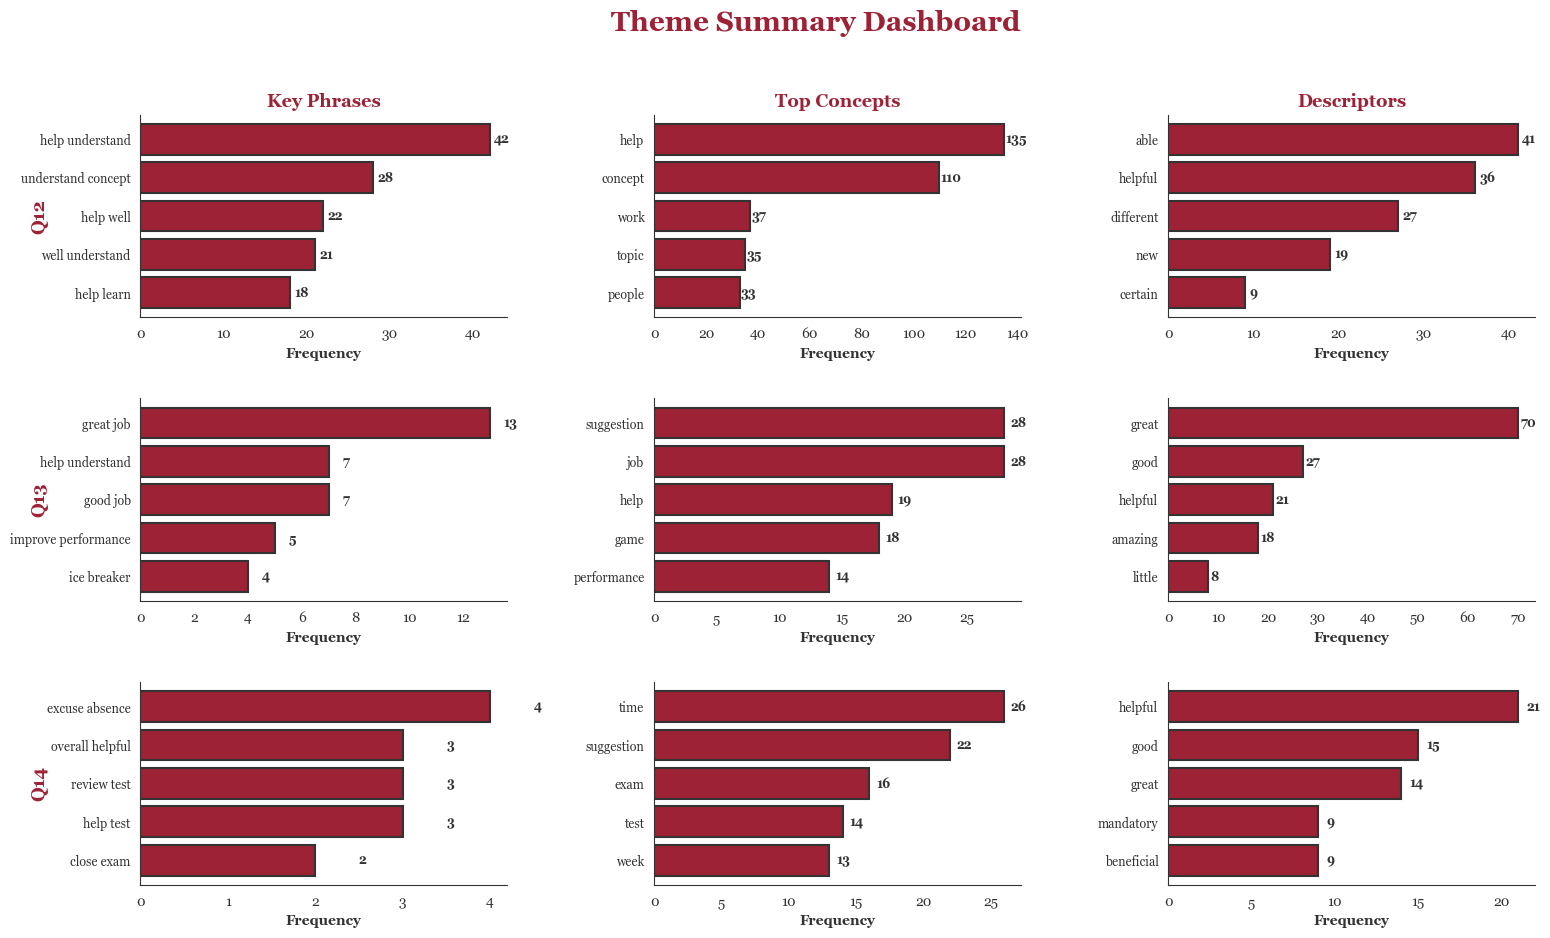

In [123]:
# Color palette.
cardinal_red = '#9D2235'
white = '#FFFFFF'
dark_gray = '#333333'

# Set Georgia font.
plt.rcParams['font.family'] = 'Georgia'

# Empty lists to hold theme topics and top phrases.
theme_data = {}
top_n = 5

# For every question.
for q_id in df_filtered['question_id'].unique():
    q_data = df_filtered[df_filtered['question_id'] == q_id]
    
    # Get top bigrams.
    all_ngrams = []
    for ngrams in q_data['ngrams']:
        all_ngrams.extend(safe_parse_list(ngrams))
    top_bigrams = Counter(all_ngrams).most_common(top_n)
    
    # Get top nouns.
    all_nouns = []
    for nouns in q_data.iloc[:, 7]:  
        all_nouns.extend(safe_parse_list(nouns))
    top_nouns = Counter(all_nouns).most_common(top_n)
    
    # Get top adjectives.
    all_adj = []
    for adj in q_data.iloc[:, 9]: 
        all_adj.extend(safe_parse_list(adj))
    top_adj = Counter(all_adj).most_common(top_n)
    
    theme_data[q_id] = {
        'bigrams': top_bigrams,
        'nouns': top_nouns,
        'adjectives': top_adj
    }

# Create Dashboard.
fig = plt.figure(figsize=(18, 10), facecolor=white)
gs = fig.add_gridspec(3, 3, hspace=0.4, wspace=0.4)

question_ids = list(theme_data.keys())

# Create visualizations for each question.
for q_idx, q_id in enumerate(question_ids):
    data = theme_data[q_id]
    
    # Collect bigrams and plot them on each graph, for each question.
    ax_bigrams = fig.add_subplot(gs[q_idx, 0])
    if data['bigrams']:
        phrases, freqs = zip(*data['bigrams'])
        bars = ax_bigrams.barh(range(len(phrases)), freqs, 
                               color=cardinal_red, edgecolor=dark_gray, linewidth=1.5)
        ax_bigrams.set_yticks(range(len(phrases)))
        ax_bigrams.set_yticklabels(phrases, fontsize=9, color=dark_gray)
        ax_bigrams.set_xlabel('Frequency', fontsize=10, fontweight='bold', color=dark_gray)
        ax_bigrams.invert_yaxis()
        ax_bigrams.grid(False)
        ax_bigrams.set_facecolor(white)
        ax_bigrams.spines['top'].set_visible(False)
        ax_bigrams.spines['right'].set_visible(False)
        ax_bigrams.spines['left'].set_color(dark_gray)
        ax_bigrams.spines['bottom'].set_color(dark_gray)
        ax_bigrams.tick_params(colors=dark_gray)
        
        # Add frequency labels.
        for i, (bar, freq) in enumerate(zip(bars, freqs)):
            ax_bigrams.text(freq + 0.5, i, str(freq), 
                           va='center', fontsize=9, fontweight='bold', color=dark_gray)
        
        if q_idx == 0:
            ax_bigrams.set_title('Key Phrases', fontsize=13, fontweight='bold', color=cardinal_red)
        
        # Y-axis labels.
        ax_bigrams.text(-0.25, 0.5, q_id, transform=ax_bigrams.transAxes,
                       fontsize=13, fontweight='bold', rotation=90,
                       va='center', ha='right', color=cardinal_red)
    
    # Top Concepts (Nouns).
    ax_nouns = fig.add_subplot(gs[q_idx, 1])
    if data['nouns']:
        concepts, freqs = zip(*data['nouns'])
        bars = ax_nouns.barh(range(len(concepts)), freqs, 
                            color=cardinal_red, edgecolor=dark_gray, linewidth=1.5)
        ax_nouns.set_yticks(range(len(concepts)))
        ax_nouns.set_yticklabels(concepts, fontsize=9, color=dark_gray)
        ax_nouns.set_xlabel('Frequency', fontsize=10, fontweight='bold', color=dark_gray)
        ax_nouns.invert_yaxis()
        ax_nouns.grid(False)
        ax_nouns.set_facecolor(white)
        ax_nouns.spines['top'].set_visible(False)
        ax_nouns.spines['right'].set_visible(False)
        ax_nouns.spines['left'].set_color(dark_gray)
        ax_nouns.spines['bottom'].set_color(dark_gray)
        ax_nouns.tick_params(colors=dark_gray)
        
        for i, (bar, freq) in enumerate(zip(bars, freqs)):
            ax_nouns.text(freq + 0.5, i, str(freq), 
                         va='center', fontsize=9, fontweight='bold', color=dark_gray)
        
        if q_idx == 0:
            ax_nouns.set_title('Top Concepts', fontsize=13, fontweight='bold', color=cardinal_red)
    
    # Descriptors (Adjectives).
    ax_adj = fig.add_subplot(gs[q_idx, 2])
    if data['adjectives']:
        descriptors, freqs = zip(*data['adjectives'])
        bars = ax_adj.barh(range(len(descriptors)), freqs, 
                          color=cardinal_red, edgecolor=dark_gray, linewidth=1.5)
        ax_adj.set_yticks(range(len(descriptors)))
        ax_adj.set_yticklabels(descriptors, fontsize=9, color=dark_gray)
        ax_adj.set_xlabel('Frequency', fontsize=10, fontweight='bold', color=dark_gray)
        ax_adj.invert_yaxis()
        ax_adj.grid(False)
        ax_adj.set_facecolor(white)
        ax_adj.spines['top'].set_visible(False)
        ax_adj.spines['right'].set_visible(False)
        ax_adj.spines['left'].set_color(dark_gray)
        ax_adj.spines['bottom'].set_color(dark_gray)
        ax_adj.tick_params(colors=dark_gray)
        
        for i, (bar, freq) in enumerate(zip(bars, freqs)):
            ax_adj.text(freq + 0.5, i, str(freq), 
                       va='center', fontsize=9, fontweight='bold', color=dark_gray)
        
        if q_idx == 0:
            ax_adj.set_title('Descriptors', fontsize=13, fontweight='bold', color=cardinal_red)

# Add a plot title.
fig.suptitle('Theme Summary Dashboard', 
             fontsize=20, fontweight='bold', y=0.985, color=cardinal_red)
plt.tight_layout(rect=[0, 0, 1, 0.97])

# BERTopic

In [125]:
# Use the 'response' column for analysis.
docs = df_filtered['response'].tolist()
question_ids = df_filtered['question_id'].tolist()

print(f"Total responses to analyze: {len(docs)}")
print(f"Questions: {df_filtered['question_id'].unique()}")

Total responses to analyze: 902
Questions: ['Q12' 'Q13' 'Q14']


In [127]:
# Use a pre-trained sentence transformer.
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")

# Custom stopwords - add survey-specific filler words.
custom_stop_words = [
    'think', 'really', 'just', 'like', 'dont', 'don', 'know',
    'honestly', 'maybe', 'probably', 'kind', 'sort',
    've', 't', 's', 'll', 'hasn', 'doesnt', 'didnt', 'isnt', 'arent', 'wasnt', 'werent'
]

In [ ]:
# Combine with English stopwords.
all_stop_words = list(set(custom_stop_words) | set(CountVectorizer(stop_words='english').get_stop_words()))


In [129]:
# Custom vectorizer with better stopwords.
vectorizer_model = CountVectorizer(
    ngram_range=(1, 2),
    stop_words=all_stop_words,
    min_df=1 
)

In [130]:
all_results = {}

for q_id in df_filtered['question_id'].unique():
    print(f"\n{'='*80}")
    print(f"Analyzing {q_id}")
    print(f"{'='*80}")
    
    # Get responses for this question only
    q_data = df_filtered[df_filtered['question_id'] == q_id]
    q_docs = q_data['response'].tolist()
    
    print(f"Number of responses: {len(q_docs)}")
    
    # Create fresh model for this question with better settings
    topic_model = BERTopic(
        embedding_model=sentence_model,
        vectorizer_model=vectorizer_model,
        min_topic_size=15,  # Increased from 10 - need more substantial topics
        nr_topics="auto",
        verbose=False,
        calculate_probabilities=True
    )
    
    # Fit model
    print("Finding topics...")
    topics, probs = topic_model.fit_transform(q_docs)
    
    # Store results
    all_results[q_id] = {
        'docs': q_docs,
        'topics': topics,
        'probs': probs,
        'model': topic_model
    }
    
    n_topics = len(set(topics)) - (1 if -1 in topics else 0)
    print(f"✅ Found {n_topics} topics")


Analyzing Q12
Number of responses: 342
Finding topics...
✅ Found 3 topics

Analyzing Q13
Number of responses: 289
Finding topics...
✅ Found 3 topics

Analyzing Q14
Number of responses: 271
Finding topics...
✅ Found 3 topics


In [81]:
for q_id, results in all_results.items():
    print(f"\n{q_id}")
    print("=" * 80)
    
    docs = results['docs']
    topics = results['topics']
    probs = results['probs']
    model = results['model']
    
    # Extract probability for assigned topic (probs is 2D, we need 1D)
    if probs is not None and len(probs.shape) > 1:
        # Get max probability for each document
        topic_probs = np.max(probs, axis=1)
    else:
        # If probs is already 1D or None, use as is
        topic_probs = probs if probs is not None else [1.0] * len(docs)
    
    # Create dataframe
    df_results = pd.DataFrame({
        'doc': docs,
        'topic': topics,
        'prob': topic_probs
    })
    
    # For each topic, show examples
    unique_topics = sorted([t for t in set(topics) if t != -1])
    
    for topic_num in unique_topics:
        # Get topic words
        topic_words = model.get_topic(topic_num)
        if topic_words:
            top_words = ', '.join([word for word, _ in topic_words[:5]])
        else:
            top_words = "N/A"
        
        topic_docs = df_results[df_results['topic'] == topic_num]
        
        print(f"\nTopic {topic_num}: {top_words}")
        print(f"Count: {len(topic_docs)} responses")
        print("-" * 80)
        
        # Get 3 most representative responses
        top_examples = topic_docs.nlargest(3, 'prob')
        
        for idx, (_, row) in enumerate(top_examples.iterrows(), 1):
            doc_text = row['doc']
            if len(doc_text) > 150:
                doc_text = doc_text[:147] + "..."
            print(f"\n  Example {idx}:")
            print(f"  {doc_text}")
    
    print()


Q12

Topic 0: helped, understand, concepts, better, helps
Count: 305 responses
--------------------------------------------------------------------------------

  Example 1:
  Collaborating with classmates during SI is is helpful as the activities helped me gain a better understanding of the concepts. 

  Example 2:
  It's allowed me to discuss concepts that I wasn't completely sure of before. Going over some of the older test questions with my classmates helps m...

  Example 3:
  it has truly allowed me to fully understand everything by communicating.

Topic 1: helped, good, yes, helped helped, helpful
Count: 37 responses
--------------------------------------------------------------------------------

  Example 1:
  It went well!

  Example 2:
  Amazing

  Example 3:
  good


Q13

Topic 0: great, si, leader, did, si leader
Count: 236 responses
--------------------------------------------------------------------------------

  Example 1:
  More games related to course material, thos

# Actionable

In [87]:
request_patterns = {
    'Practice Materials': [
        r'practice\s+(test|exam|question|problem|guide)',
        r'study\s+guide',
        r'review\s+(sheet|material|guide)',
        r'sample\s+(test|exam|question)',
        r'old\s+(test|exam)',
        r'past\s+(test|exam|question)'
    ],
    'More Sessions/Time': [
        r'more\s+(session|time|class|meeting)',
        r'additional\s+(session|time|class)',
        r'longer\s+(session|class)',
        r'extend\s+(session|time)',
        r'extra\s+(session|time|class)'
    ],
    'Games/Activities': [
        r'(more|additional)?\s*(game|kahoot|activity|activities)',
        r'interactive',
        r'fun\s+(activity|activities)',
        r'ice\s*breaker'
    ],
    'Attendance/Flexibility': [
        r'(attendance|absent|absence|miss|excus)',
        r'flexible\s+(schedule|time)',
        r'different\s+time',
        r'schedule\s+(conflict|issue)'
    ],
    'Content/Material': [
        r'(more|better|different)\s+(example|explanation)',
        r'go\s+over',
        r'review\s+(more|better)',
        r'cover\s+(more|different)',
        r'focus\s+on'
    ],
    'Session Structure': [
        r'(structure|format|organization)',
        r'how\s+(session|class)\s+(run|organized)',
        r'break\s+up',
        r'pace|pacing'
    ]
}

In [88]:
def find_matching_requests(responses, patterns):
    """Find responses that match any of the patterns"""
    matches = []
    for response in responses:
        response_lower = str(response).lower()
        for pattern in patterns:
            if re.search(pattern, response_lower):
                matches.append(response)
                break  # Only add once per response
    return matches

In [99]:
all_categorized_requests = []

for q_id in df_filtered['question_id'].unique():
    q_data = df_filtered[df_filtered['question_id'] == q_id]
    
    print(f"{q_id}: {q_data['question_text'].iloc[0]}")
    
    # Get all request responses
    request_responses = q_data[q_data['category'] == 'Request']['response'].tolist()
    
    if not request_responses:
        print("No specific requests found.\n")
        continue
    
    print(f"Total requests: {len(request_responses)}\n")
    
    # Find matches for each category
    found_any = False
    
    for category, patterns in request_patterns.items():
        matches = find_matching_requests(request_responses, patterns)
        
        if matches:
            found_any = True
            print(f"{category} ({len(matches)} requests)")
            
            # Show up to 5 examples
            for i, response in enumerate(matches[:5], 1):
                # Truncate if too long
                response_display = response if len(response) <= 150 else response[:147] + "..."
                print(f"  {i}. \"{response_display}\"")
            
            if len(matches) > 5:
                print(f"  ... and {len(matches) - 5} more similar requests")
            
            print()
            
            # Save to list for DataFrame
            for response in matches:
                all_categorized_requests.append({
                    'question_id': q_id,
                    'request_category': category,
                    'response': response
                })
    
    # For requests that didn't match any category
    if not found_any:
        print("No requests matched specific categories. Showing general requests:")
        for i, response in enumerate(request_responses[:10], 1):
            response_display = response if len(response) <= 150 else response[:147] + "..."
            print(f"  {i}. \"{response_display}\"")
        print()
        
        # Save uncategorized requests
        for response in request_responses:
            all_categorized_requests.append({
                'question_id': q_id,
                'request_category': 'Other/General',
                'response': response
            })

# Create DataFrame
requests_df = pd.DataFrame(all_categorized_requests)

Q12: How has working collaboratively with your SI classmates contributed to your understanding of course concepts?
Total requests: 117

Games/Activities (9 requests)
  1. "Collaborating with classmates during SI is is helpful as the activities helped me gain a better understanding of the concepts. "
  2. "It has helped me understand the material better by doing fun activities to help understand the material better."
  3. "My SI leader has us work together in class to discuss concepts and better learn the material. By playing fun games in class and competing in groups..."
  4. "I have learned the concepts better by working in groups for games or activities for review and it has helped me gain understanding. "
  5. "It is helpful and comforting to be able to work with other classmates who may be struggling with or have questions about the same subjects as me. W..."
  ... and 4 more similar requests

Attendance/Flexibility (1 requests)
  1. "By bringing different perspectives from differe

In [101]:
# Show full text in columns
pd.set_option('display.max_colwidth', None)  # No limit
pd.set_option('display.max_rows', None)      # Show all rows (optional)

# Now view
requests_df

,question_id,request_category,response
0,Q12,Games/Activities,Collaborating with classmates during SI is is helpful as the activities helped me gain a better understanding of the concepts.
1,Q12,Games/Activities,It has helped me understand the material better by doing fun activities to help understand the material better.
2,Q12,Games/Activities,"My SI leader has us work together in class to discuss concepts and better learn the material. By playing fun games in class and competing in groups, this makes retaining and reviewing the class material fun and engaging."
3,Q12,Games/Activities,I have learned the concepts better by working in groups for games or activities for review and it has helped me gain understanding.
4,Q12,Games/Activities,"It is helpful and comforting to be able to work with other classmates who may be struggling with or have questions about the same subjects as me. Working together makes the topics easier to understand, because we are able to help each other with subjects that we are strong in. I also think that the activities that we do as a group make the session a less stressful and more fun environment."
5,Q12,Games/Activities,Doing group work really helps me understand concepts more because of how interactive the assignments are.
6,Q12,Games/Activities,When we played interactive games such as taboo to understand how to recognize certain terms with other words that could be said helped a lot to understand different points of view or a more broader range of what the thing we are talking about is.
7,Q12,Games/Activities,I would say that the games we played made studying fun and engaging which helped me learn some of the more difficult concepts better than if I studied on my own.
8,Q12,Games/Activities,It helped me grasp the concept better because of the activities that she provided.
9,Q12,Attendance/Flexibility,By bringing different perspectives from different students we can all work together to better understand and help each other put the missing pieces together. I feel like I have gotten a better understanding of concepts and know more about biology as a whole.


Saved: master_survey_dashboard.png


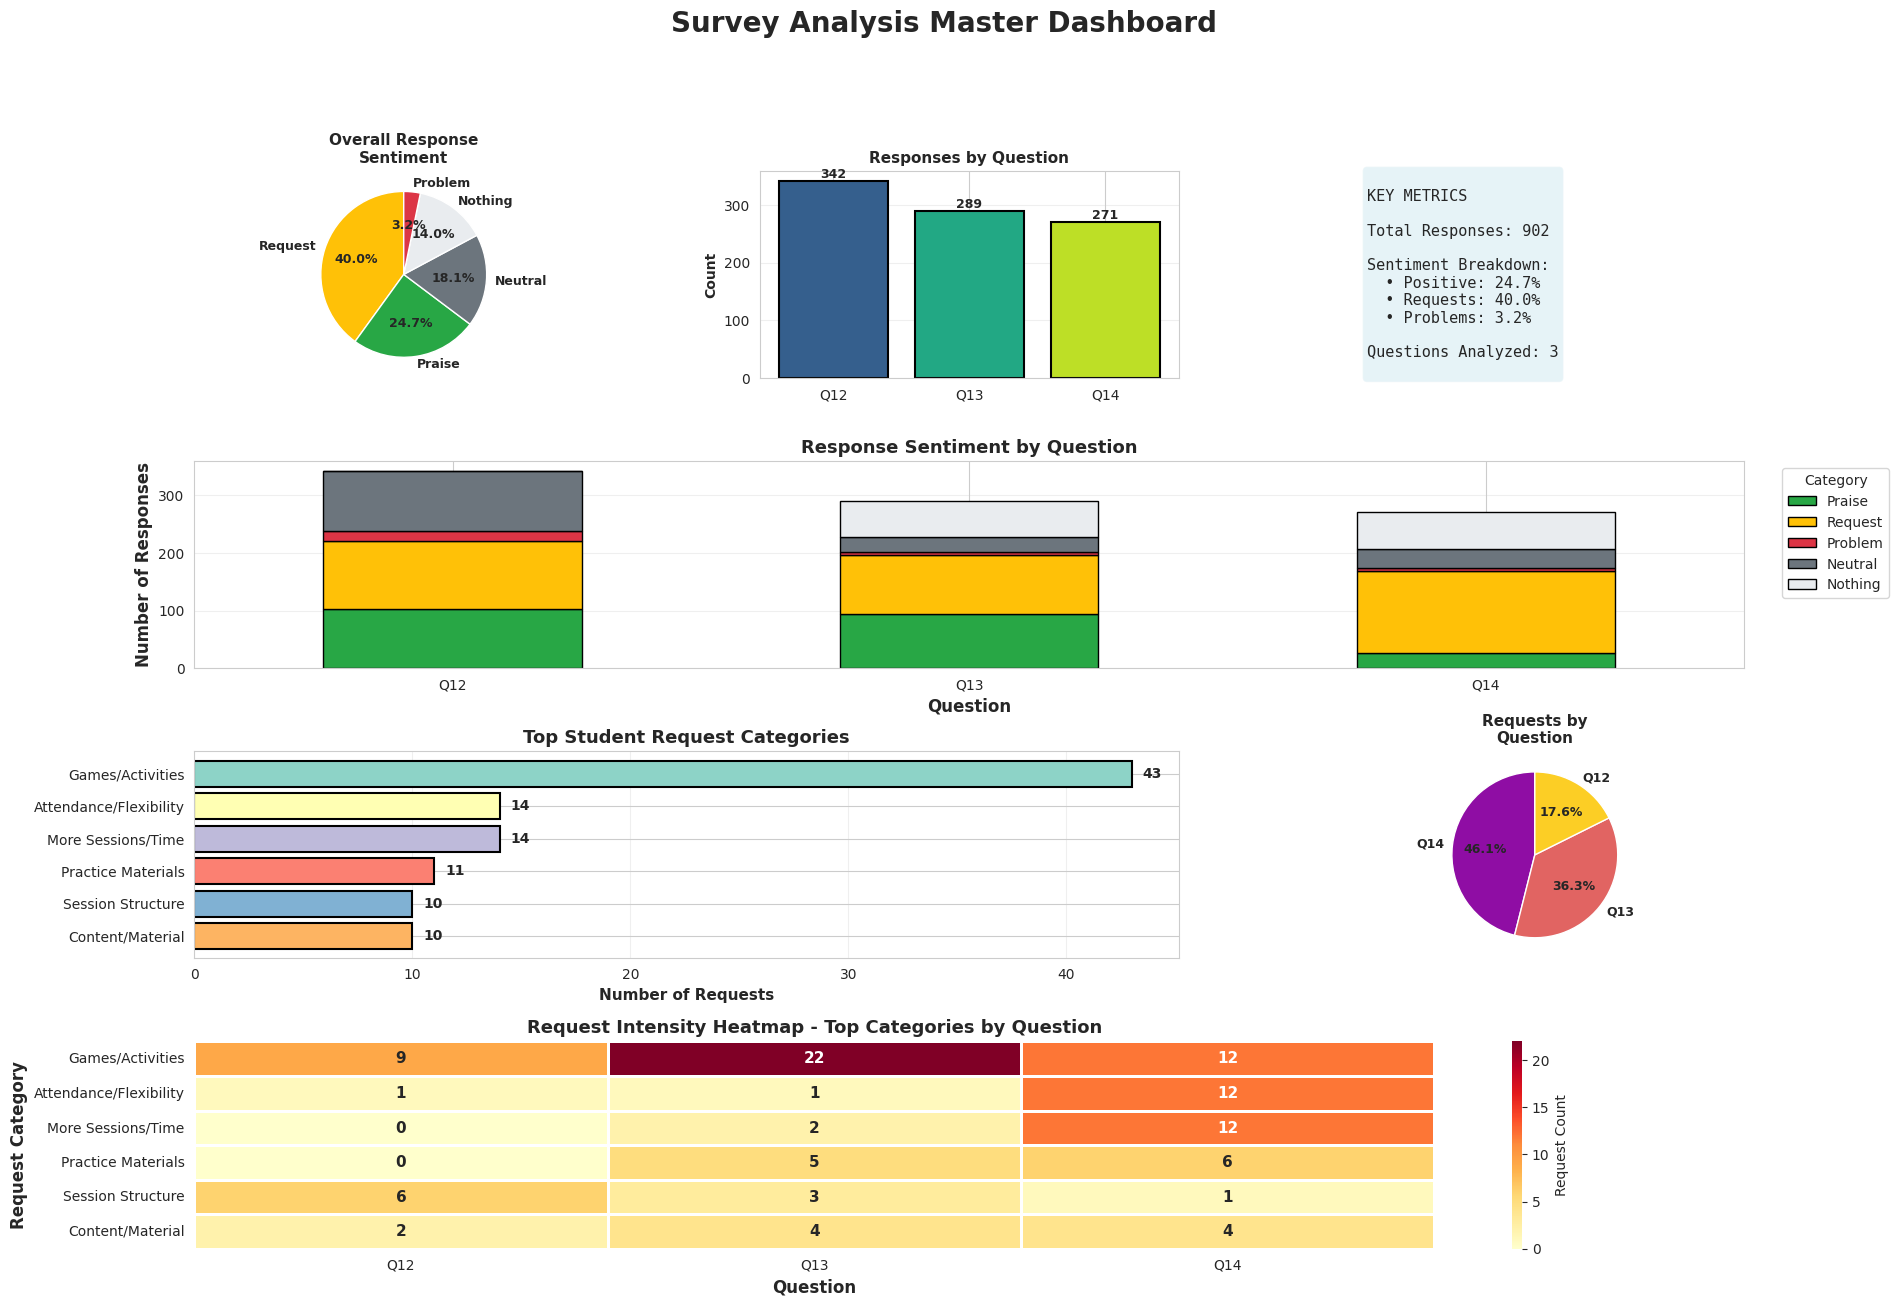

In [108]:
sns.set_style("whitegrid")

# Create master dashboard
fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(4, 3, hspace=0.4, wspace=0.35)

# Row 1: Overview metrics

# 1.1 Response Sentiment Breakdown
ax1 = fig.add_subplot(gs[0, 0])
overall_cats = df_filtered['category'].value_counts()
colors_sentiment = {'Praise': '#28a745', 'Request': '#ffc107', 'Problem': '#dc3545', 
                    'Neutral': '#6c757d', 'Nothing': '#e9ecef'}
colors_pie = [colors_sentiment.get(cat, '#cccccc') for cat in overall_cats.index]

ax1.pie(overall_cats.values, labels=overall_cats.index, autopct='%1.1f%%',
        colors=colors_pie, startangle=90,
        textprops={'fontsize': 9, 'fontweight': 'bold'})
ax1.set_title('Overall Response\nSentiment', fontsize=11, fontweight='bold')

# 1.2 Responses by Question
ax2 = fig.add_subplot(gs[0, 1])
q_counts = df_filtered['question_id'].value_counts().sort_index()
colors_q = plt.cm.viridis(np.linspace(0.3, 0.9, len(q_counts)))
bars = ax2.bar(range(len(q_counts)), q_counts.values, color=colors_q, 
               edgecolor='black', linewidth=1.5)
ax2.set_xticks(range(len(q_counts)))
ax2.set_xticklabels(q_counts.index, fontsize=10)
ax2.set_ylabel('Count', fontsize=10, fontweight='bold')
ax2.set_title('Responses by Question', fontsize=11, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
for bar, count in zip(bars, q_counts.values):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height, f'{int(count)}',
             ha='center', va='bottom', fontsize=9, fontweight='bold')

# 1.3 Key Metrics Text Box
ax3 = fig.add_subplot(gs[0, 2])
ax3.axis('off')

total_responses = len(df_filtered)
praise_pct = (df_filtered['category'] == 'Praise').sum() / total_responses * 100
request_pct = (df_filtered['category'] == 'Request').sum() / total_responses * 100
problem_pct = (df_filtered['category'] == 'Problem').sum() / total_responses * 100

metrics_text = f"""
KEY METRICS

Total Responses: {total_responses}

Sentiment Breakdown:
  • Positive: {praise_pct:.1f}%
  • Requests: {request_pct:.1f}%
  • Problems: {problem_pct:.1f}%

Questions Analyzed: {len(q_counts)}
"""

ax3.text(0.1, 0.5, metrics_text, fontsize=11, family='monospace',
         verticalalignment='center',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))

# Row 2: Sentiment by question

ax4 = fig.add_subplot(gs[1, :])

category_by_q = df_filtered.groupby(['question_id', 'category']).size().unstack(fill_value=0)
column_order = ['Praise', 'Request', 'Problem', 'Neutral', 'Nothing']
category_by_q = category_by_q[[col for col in column_order if col in category_by_q.columns]]

category_by_q.plot(kind='bar', stacked=True, ax=ax4,
                   color=[colors_sentiment.get(col, '#cccccc') for col in category_by_q.columns],
                   edgecolor='black', linewidth=1)

ax4.set_xlabel('Question', fontsize=12, fontweight='bold')
ax4.set_ylabel('Number of Responses', fontsize=12, fontweight='bold')
ax4.set_title('Response Sentiment by Question', fontsize=13, fontweight='bold')
ax4.legend(title='Category', bbox_to_anchor=(1.02, 1), loc='upper left')
ax4.grid(axis='y', alpha=0.3)
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=0)

# Row 3: Top request categories

ax5 = fig.add_subplot(gs[2, :2])

if len(requests_df) > 0:
    category_counts = requests_df['request_category'].value_counts().head(8)
    colors_cat = plt.cm.Set3(range(len(category_counts)))
    
    bars = ax5.barh(range(len(category_counts)), category_counts.values,
                    color=colors_cat, edgecolor='black', linewidth=1.5)
    
    ax5.set_yticks(range(len(category_counts)))
    ax5.set_yticklabels(category_counts.index, fontsize=10)
    ax5.set_xlabel('Number of Requests', fontsize=11, fontweight='bold')
    ax5.set_title('Top Student Request Categories', fontsize=13, fontweight='bold')
    ax5.invert_yaxis()
    ax5.grid(axis='x', alpha=0.3)
    
    for i, (bar, count) in enumerate(zip(bars, category_counts.values)):
        ax5.text(count + 0.5, i, str(count), va='center', fontsize=10, fontweight='bold')
else:
    ax5.text(0.5, 0.5, 'No categorized requests', ha='center', va='center',
             transform=ax5.transAxes, fontsize=12)
    ax5.set_title('Top Student Request Categories', fontsize=13, fontweight='bold')

# 3.2 Request Categories by Question (Pie breakdown)
ax6 = fig.add_subplot(gs[2, 2])

if len(requests_df) > 0:
    q_request_counts = requests_df['question_id'].value_counts()
    colors_q_req = plt.cm.plasma(np.linspace(0.3, 0.9, len(q_request_counts)))
    
    ax6.pie(q_request_counts.values, labels=q_request_counts.index, autopct='%1.1f%%',
            colors=colors_q_req, startangle=90,
            textprops={'fontsize': 9, 'fontweight': 'bold'})
    ax6.set_title('Requests by\nQuestion', fontsize=11, fontweight='bold')
else:
    ax6.text(0.5, 0.5, 'No requests', ha='center', va='center',
             transform=ax6.transAxes, fontsize=12)
    ax6.set_title('Requests by Question', fontsize=11, fontweight='bold')

# Row 4: Request heatmap

ax7 = fig.add_subplot(gs[3, :])

if len(requests_df) > 0:
    # Get top 6 categories
    top_cats = requests_df['request_category'].value_counts().head(6).index
    
    # Create heatmap
    heatmap_data = []
    question_ids = sorted(df_filtered['question_id'].unique())
    
    for cat in top_cats:
        row = []
        for q_id in question_ids:
            count = len(requests_df[(requests_df['question_id'] == q_id) & 
                                    (requests_df['request_category'] == cat)])
            row.append(count)
        heatmap_data.append(row)
    
    heatmap_df = pd.DataFrame(heatmap_data, columns=question_ids, index=top_cats)
    
    sns.heatmap(heatmap_df, annot=True, fmt='g', cmap='YlOrRd',
                linewidths=1, cbar_kws={'label': 'Request Count'},
                ax=ax7, annot_kws={'fontsize': 11, 'fontweight': 'bold'})
    
    ax7.set_xlabel('Question', fontsize=12, fontweight='bold')
    ax7.set_ylabel('Request Category', fontsize=12, fontweight='bold')
    ax7.set_title('Request Intensity Heatmap - Top Categories by Question', fontsize=13, fontweight='bold')
else:
    ax7.text(0.5, 0.5, 'No categorized requests to display', ha='center', va='center',
             transform=ax7.transAxes, fontsize=12)
    ax7.set_title('Request Intensity Heatmap', fontsize=13, fontweight='bold')

# Title

plt.suptitle('Survey Analysis Master Dashboard', fontsize=20, fontweight='bold', y=0.995)

plt.savefig('master_survey_dashboard.png', dpi=300, bbox_inches='tight')
print("Saved: master_survey_dashboard.png")
plt.show()

In [113]:
df_filtered[df_filtered['category'] == 'Problem']


,question_id,question_text,response,processed_tokens,processed_text,ngrams,entities,pos_tokens,nouns,verbs,adjectives,adverbs,category
52,Q12,How has working collaboratively with your SI classmates contributed to your understanding of course concepts?,It is beneficial to helping figure out the material however it makes it hard when it is the same people over and over,"[beneficial, help, figure, material, hard, people]",beneficial help figure material hard people,"[beneficial help, beneficial help figure, figure material, hard people, help figure, help figure material]",[],"{'nouns': ['help', 'figure', 'material', 'people'], 'verbs': ['make'], 'adjectives': ['beneficial', 'hard'], 'adverbs': []}","[help, figure, material, people]",[],"[beneficial, hard]",[],Problem
70,Q12,How has working collaboratively with your SI classmates contributed to your understanding of course concepts?,It has made me think harder on the concepts.,"[hard, concept, .]",hard concept .,[hard concept],[],"{'nouns': ['concept'], 'verbs': ['think'], 'adjectives': ['hard'], 'adverbs': []}",[concept],[],[hard],[],Problem
82,Q12,How has working collaboratively with your SI classmates contributed to your understanding of course concepts?,Working collaboratively with my SI classmates has significantly increased my understanding of the course content. I struggle with science and having people to talk things over with every week has been very beneficial.,"[work, collaboratively, significantly, increase, understanding, content, ., struggle, science, have, people, talk, week, beneficial, .]",work collaboratively significantly increase understanding content . struggle science have people talk week beneficial .,"[content struggle, content struggle science, have people, have people talk, increase understanding, people talk, science have, science have people, significantly increase, significantly increase understanding, struggle science, struggle science have, week beneficial, work collaboratively]",[],"{'nouns': ['instruction', 'classmate', 'course', 'content', 'science', 'people', 'thing', 'week'], 'verbs': ['work', 'increase', 'understand', 'struggle', 'talk'], 'adjectives': ['supplemental', 'beneficial'], 'adverbs': ['collaboratively', 'significantly']}","[content, science, people, week]","[work, increase, understand, struggle, talk]",[beneficial],"[collaboratively, significantly]",Problem
85,Q12,How has working collaboratively with your SI classmates contributed to your understanding of course concepts?,I think it helps with a general understanding of the class or and grasping difficult topics,"[help, general, understanding, grasp, difficult, topic]",help general understanding grasp difficult topic,"[difficult topic, general understanding, grasp difficult, grasp difficult topic, help general, help general understanding]",[],"{'nouns': ['understanding', 'class', 'grasp', 'topic'], 'verbs': ['think', 'help'], 'adjectives': ['general', 'difficult'], 'adverbs': []}","[understanding, grasp, topic]",[help],"[general, difficult]",[],Problem
91,Q12,How has working collaboratively with your SI classmates contributed to your understanding of course concepts?,It has allowed me to open my mind to new problem solving techniques,"[allow, open, mind, new, problem, solve, technique]",allow open mind new problem solve technique,"[allow open, allow open mind, mind new, mind new problem, new problem, new problem solve, open mind, open mind new, problem solve, problem solve technique, solve technique]",[],"{'nouns': ['mind', 'problem', 'technique'], 'verbs': ['allow', 'solve'], 'adjectives': ['open', 'new'], 'adverbs': []}","[mind, problem, technique]","[allow, solve]","[open, new]",[],Problem
166,Q12,How has working collaboratively with your SI classmates contributed to your understanding of course concepts?,Some of us struggle in different concepts and we have been able to help each other out.,"[struggle, different, concept, able, help, .]",struggle different concept able help .,"[a